In [1]:
# Imports
import sctoolbox
import sctoolbox.tools.qc_filter as qc
import sctoolbox.utils as utils
import sctoolbox.tools as tools
import sctoolbox.plotting as pl

import peakqc.insertsizes as ins
import peakqc.fld_scoring as fld

import matplotlib.pyplot as plt
import matplotlib
import episcanpy as epi
import pandas as pd
import scrublet as scr
import os
import numpy as np
import scanpy as sc

# type hint imports
from beartype.typing import Tuple, Dict, Optional, Literal, Callable, Iterable, Any  # , Union, List
import numpy.typing as npt

In [2]:
# Sample
sample = 'right_atrium_auricular_region_IOBHN'

# Absolute minimum number of features for pre-selection of cells before QC 
min_genes = 1

# Choose whether to binarize the X matrix
binarize_mtx = False  # True or False; convert matrix to binary

# Available threads
threads = 8

# Set default filter thresholds
# This will be applied to all samples - the thresholds can be changed manually when plotted 
use_default_thresholds = True  # set to False to ignore default_thresholds
thresholds = {
              'fld_score_1': {'column': 'fld_score', 'min': 0, 'max': 100},
              'fld_score_2': {'column': 'fld_score', 'min': 100, 'max': 200},
              'fld_score_3': {'column': 'fld_score', 'min': 200, 'max': 500},
              'fld_score_4': {'column': 'fld_score', 'min': 500, 'max': 1000},
              #'fld_score_5': {'column': 'fld_score', 'min': 400, 'max': 800},
              #'fld_score_6': {'column': 'fld_score', 'min': 800, 'max': 1000},
    
              'nucleosome_signal_1': {'column': 'nucleosome_signal', 'min': 0, 'max': 0.1},
              'nucleosome_signal_2': {'column': 'nucleosome_signal', 'min': 0.1, 'max': 0.7},
              'nucleosome_signal_3': {'column': 'nucleosome_signal', 'min': 0.7, 'max': 2},
              'nucleosome_signal_4': {'column': 'nucleosome_signal', 'min': 2, 'max': 10},
              #'nucleosome_signal_5': {'column': 'nucleosome_signal', 'min': 2, 'max': 4},
              #'nucleosome_signal_6': {'column': 'nucleosome_signal', 'min': 4, 'max': 10},
             }

# Annotate regions to genes
GTF_PATH = '/mnt/flatfiles/organisms/new_organism/homo_sapiens/104/homo_sapiens.104.genes.gtf'  # genes gtf file
fragments = f'/mnt/workspace2/jdetlef/peakqc_paperprep/benchmarking/data/fragments/fragments_{sample}.bed'

In [3]:
work_dir = os.getcwd()

h5ad_path, current_dir = os.path.split(work_dir)

while current_dir != 'benchmarking':
    h5ad_path, current_dir = os.path.split(h5ad_path)
    
h5ad_path = os.path.join(h5ad_path, current_dir)
h5ad_path = os.path.join(h5ad_path, 'assembled')
h5ad_path = os.path.join(h5ad_path, f'{sample}.h5ad')

adata = utils.adata.load_h5ad(h5ad_path)

with pd.option_context("display.max.rows", 5, "display.max.columns", None):
    display(adata)
    display(adata.obs)
    display(adata.var)

[INFO] The adata object was loaded from: /mnt/workspace2/jdetlef/peakqc_paperprep/benchmarking/assembled/right_atrium_auricular_region_IOBHN.h5ad


AnnData object with n_obs × n_vars = 73582 × 105042
    obs: 'TN', 'UM', 'PP', 'UQ', 'CM', 'file', 'sample', 'nucleosome_signal', 'fld_score', 'mean_fragment_size', 'n_fragments', 'fold_change_promoters_fragments', 'frip', 'tsse_score', 'catlas_ov', 'cell type'
    var: 'peak_chr', 'peak_start', 'peak_end'
    uns: 'files', 'sctoolbox'

TN      UM      PP      UQ     CM  \
barcode                                                         
AAACTACCAGAAACCCGAGATA    28.0    21.0    21.0    21.0    1.0   
AAACTACCAGAAACCTAAGTGG  7116.0  6025.0  6011.0  6011.0  218.0   
...                        ...     ...     ...     ...    ...   
TTCCATCCTCTTTGCCGGAAGG     5.0     5.0     5.0     5.0    0.0   
TTCCATCCTCTTTGTGTTACCG   629.0   518.0   517.0   517.0   39.0   

                                                                     file  \
barcode                                                                     
AAACTACCAGAAACCCGAGATA  /mnt/workspace2/jdetlef/peakqc_paperprep/bench...   
AAACTACCAGAAACCTAAGTGG  /mnt/workspace2/jdetlef/peakqc_paperprep/bench...   
...                                                                   ...   
TTCCATCCTCTTTGCCGGAAGG  /mnt/workspace2/jdetlef/peakqc_paperprep/bench...   
TTCCATCCTCTTTGTGTTACCG  /mnt/workspace2/jdetlef/peakqc_paperprep/bench...   

                       sample  nucleosome_signal   fld_score  \
barcode                                                        
AAACTACCAGAAACCCGAGATA     MB           1.000000    0.003301   
AAACTACCAGAAACCTAAGTGG     MB           0.434524  305.939935   
...                       ...                ...         ...   
TTCCATCCTCTTTGCCGGAAGG     MB           1.000000    0.053747   
TTCCATCCTCTTTGTGTTACCG     MB           0.294118   40.761008   

                        mean_fragment_size  n_fragments  \
barcode                                                   
AAACTACCAGAAACCCGAGATA              117.23         13.0   
AAACTACCAGAAACCTAAGTGG              132.91       5861.0   
...                                    ...          ...   
TTCCATCCTCTTTGCCGGAAGG              135.67          3.0   
TTCCATCCTCTTTGTGTTACCG              137.91        487.0   

                        fold_change_promoters_fragments      frip  tsse_score  \
barcode                                                                         
AAACTACCAGAAACCCGAGATA                         0.076923  0.384615    1.000000   
AAACTACCAGAAACCTAAGTGG                         0.163795  0.112779    1.513383   
...                                                 ...       ...         ...   
TTCCATCCTCTTTGCCGGAAGG                         0.000000  0.333333    0.000000   
TTCCATCCTCTTTGTGTTACCG                         0.349076  0.336756    5.337278   

                        catlas_ov cell type  
barcode                                      
AAACTACCAGAAACCCGAGATA      False       NaN  
AAACTACCAGAAACCTAAGTGG      False       NaN  
...                           ...       ...  
TTCCATCCTCTTTGCCGGAAGG      False       NaN  
TTCCATCCTCTTTGTGTTACCG      False       NaN  

[73582 rows x 16 columns]

peak_chr  peak_start  peak_end
name                                                 
chr1:10007-10565           chr1       10007     10565
chr1:11182-11364           chr1       11182     11364
...                         ...         ...       ...
chrY:56870833-56870955     chrY    56870833  56870955
chrY:56886632-56886906     chrY    56886632  56886906

[105042 rows x 3 columns]

In [4]:
print('original shape:')
print(adata.shape)
print('Removing empty features and cells...')

adata = adata[adata.X.sum(axis=1) > 0]
adata = adata[:, adata.X.sum(axis=0) > 0]

print('new shape:')
print(adata.shape)

original shape:
(73582, 105042)
Removing empty features and cells...
new shape:
(69471, 101651)


<Axes: >

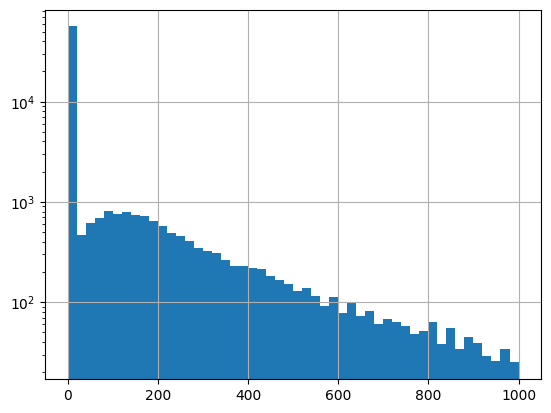

In [5]:
adata.obs['fld_score'].hist(bins=50, range=(0,1000), log=True)

<Axes: >

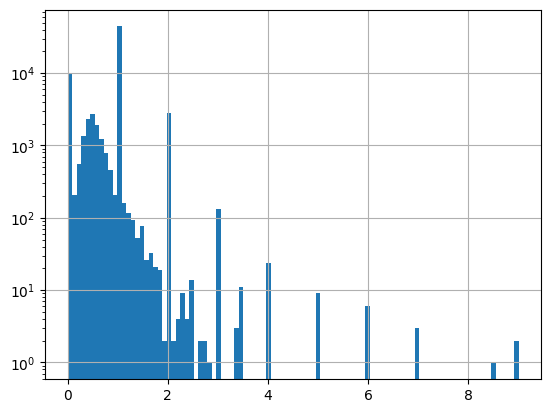

In [6]:
adata.obs['nucleosome_signal'].hist(bins=100, log=True)

In [7]:
# FLDs for subsets by scores

In [8]:
def density_plot(count_table: npt.ArrayLike,
                 max_abundance: int = 600,
                 target_height: int = 1000,
                 save: Optional[str] = None,
                 title: Optional[str] = 'Fragment Length Density Plot',
                 colormap: str = 'jet',
                 ax: Optional[matplotlib.axes.Axes] = None,
                 fig: Optional[matplotlib.figure.Figure] = None) -> npt.ArrayLike:
    """
    Plot the density of the fragment length distribution over all cells.

    The density is calculated by binning the abundances of the fragment lengths.

    Parameters
    ----------
    count_table : npt.ArrayLike
        Array of arrays of the fragment length distributions
    max_abundance : int, default 600
        Maximal abundance of a fragment length of a cell (for better visability)
    target_height : int, default 1000
        Target height of the plot
    save : Optional[str], default None
        If true, the figure is saved under the given name.
    colormap : str, default 'jet'
        Color map of the plot.
    ax : matplotlib.axes.Axes, default None
        Axes to plot on.
    fig : matplotlib.figure.Figure, default None
        Figure to plot on.

    Returns
    -------
    npt.ArrayLike
        Axes and figure of the plot.
    """
    count_table = count_table
    # handle 0,1 min/max scaled count_table
    if count_table.dtype != 'int64':
        if np.max(count_table) > 1:
            rounded = (np.round(count_table)).astype('int64')
            count_table = rounded
        else:
            count_table = (count_table * 1000).astype('int64')
    # get the maximal abundance of a fragment length over all cells
    max_value = np.max(np.around(count_table).astype(int))
    # Init empty densities list
    densities = []
    # loop over all fragment lengths from 0 to 1000
    for i in range(0, len(count_table[0])):
        column = count_table[:, i]
        # round abundances to be integers, that they are countable
        rounded = np.around(column).astype(int)
        # count the abundance of the abundances with boundaries 0 to maximal abundance
        gradient = np.bincount(rounded, minlength=max_value + 1)
        densities.append(gradient)
    densities = np.array(densities)

    # Log normalization + 1 to avoid log(0)
    densities_log = np.log1p(densities)

    # Transpose the matrix
    densities = densities_log.T

    # get the section of interest
    densities = densities[:max_abundance]

    # calculate the mean of the FLD
    mean = count_table.sum(axis=0) / len(count_table)

    # Stretch or compress densities' y-axis to the target height
    num_rows = densities.shape[0]
    old_y = np.linspace(0, num_rows - 1, num_rows)
    new_y = np.linspace(0, num_rows - 1, 1000)

    # Interpolate the densities along the y-axis
    densities_interpolated = np.array([np.interp(new_y, old_y, densities[:, i]) for i in range(densities.shape[1])]).T

    # scaling factor for mean
    scaling_factor = len(new_y) / len(old_y)

    # Apply the scaling factor to the mean values
    mean_interpolated = mean * scaling_factor

    # Initialize subplots
    if ax is None:
        main_plot = True
        fig, ax = plt.subplots()
    else:
        main_plot = False

    # Display the image
    im = ax.imshow(densities_interpolated, aspect='auto', origin="lower", cmap=colormap)

    # Plot additional data
    ax.plot(mean_interpolated, color="red", markersize=1)

    # Set labels and title
    ax.set_title(title)
    ax.set_xlabel('Fragment Length', color='blue')
    ax.set_ylabel('Number of Fragments', color='blue')

    # Adjust y-ticks to show original scale
    ax.set_yticks(np.linspace(0, target_height - 1, 6))
    ax.set_yticklabels(np.linspace(0, num_rows - 1, 6).astype(int))

    # Add colorbar to the plot
    if fig is not None:
        fig.colorbar(im, ax=ax, label='Density (log scale)')

    if main_plot:
        if save:
            plt.savefig(save)

        plt.show()

    figure = np.array([ax, fig])

    return figure

# Density FLD Plots for the Intervalls

Count insertsizes from fragments...
Starting counting fragments...


Processing Chunks: 8it [00:42,  5.36s/it]


Done reading file - elapsed time: 0:03:10
Converting counts to dataframe...
Done getting insertsizes from fragments!
58726


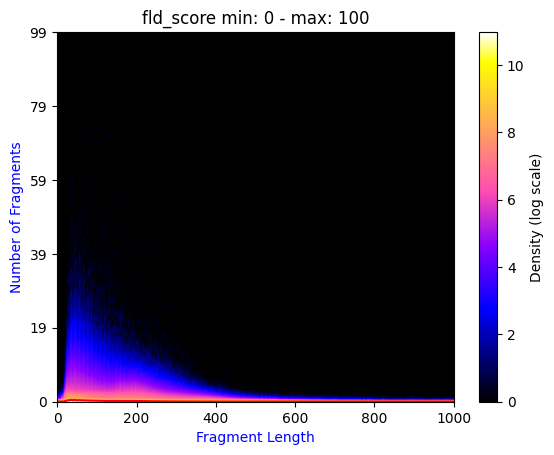

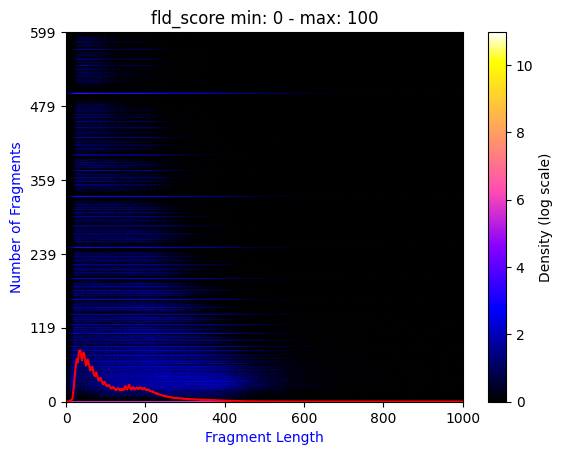

Count insertsizes from fragments...
Starting counting fragments...


Processing Chunks: 8it [00:31,  3.95s/it]


Done reading file - elapsed time: 0:00:44
Converting counts to dataframe...
Done getting insertsizes from fragments!
3655


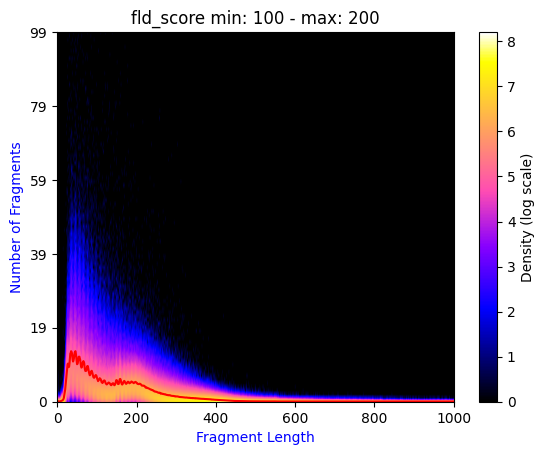

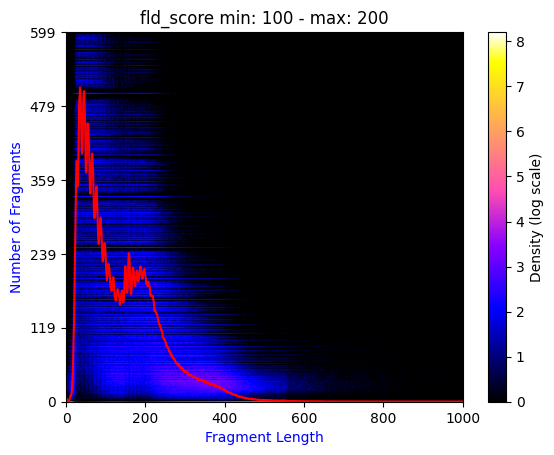

Count insertsizes from fragments...
Starting counting fragments...


Processing Chunks: 8it [00:31,  3.89s/it]


Done reading file - elapsed time: 0:00:46
Converting counts to dataframe...
Done getting insertsizes from fragments!
4573


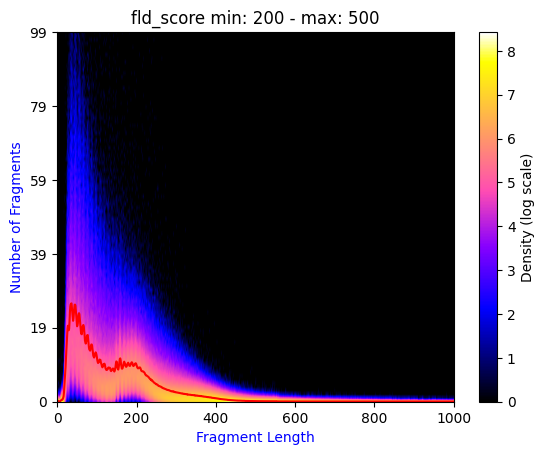

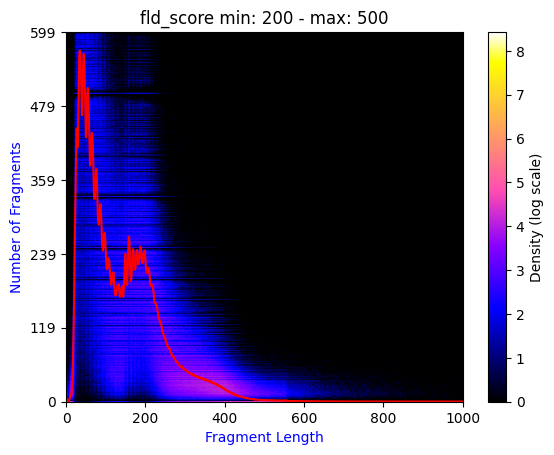

Count insertsizes from fragments...
Starting counting fragments...


Processing Chunks: 8it [00:32,  4.09s/it]


Done reading file - elapsed time: 0:00:45
Converting counts to dataframe...
Done getting insertsizes from fragments!
1652


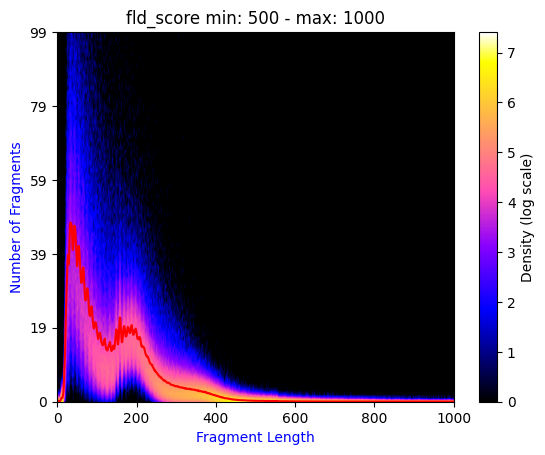

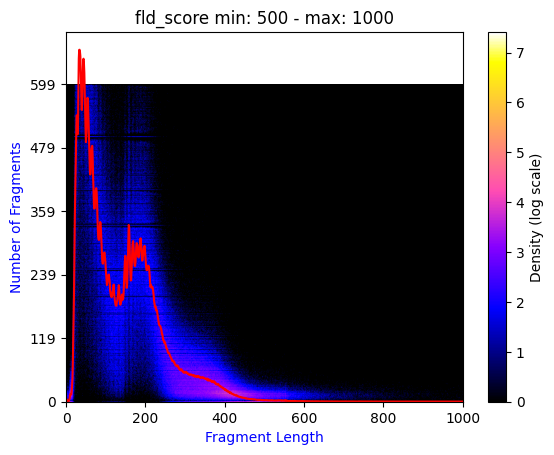

Count insertsizes from fragments...
Starting counting fragments...


Processing Chunks: 8it [00:31,  3.89s/it]


Done reading file - elapsed time: 0:00:46
Converting counts to dataframe...
Done getting insertsizes from fragments!
10007


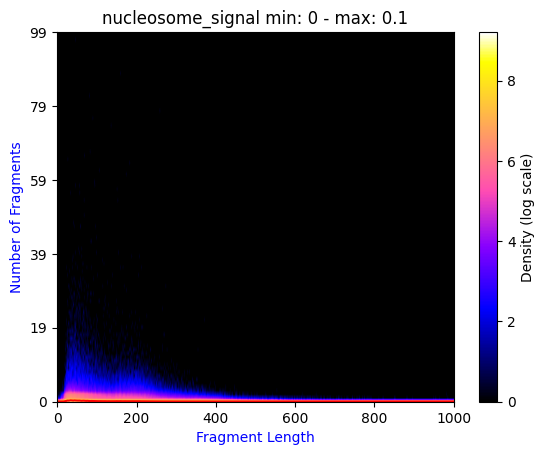

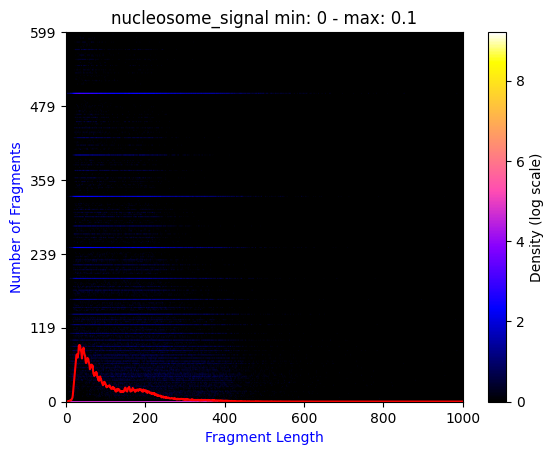

Count insertsizes from fragments...
Starting counting fragments...


Processing Chunks: 8it [00:34,  4.29s/it]


Done reading file - elapsed time: 0:01:00
Converting counts to dataframe...
Done getting insertsizes from fragments!
10073


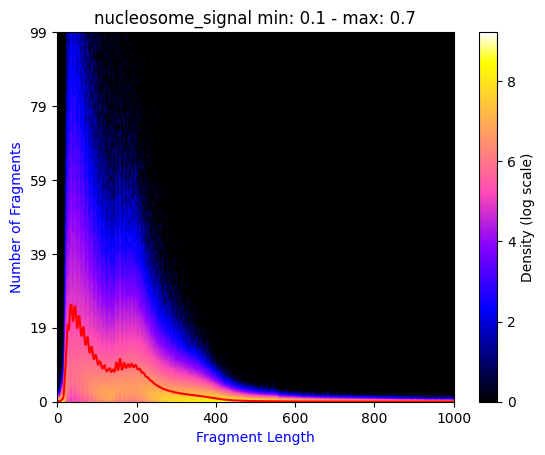

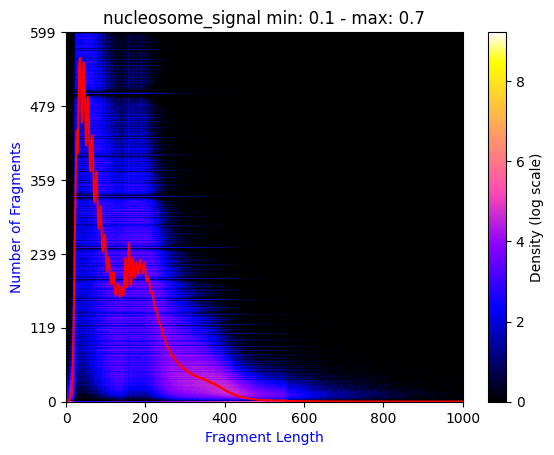

Count insertsizes from fragments...
Starting counting fragments...


Processing Chunks: 8it [00:31,  3.99s/it]


Done reading file - elapsed time: 0:02:26
Converting counts to dataframe...
Done getting insertsizes from fragments!
49226


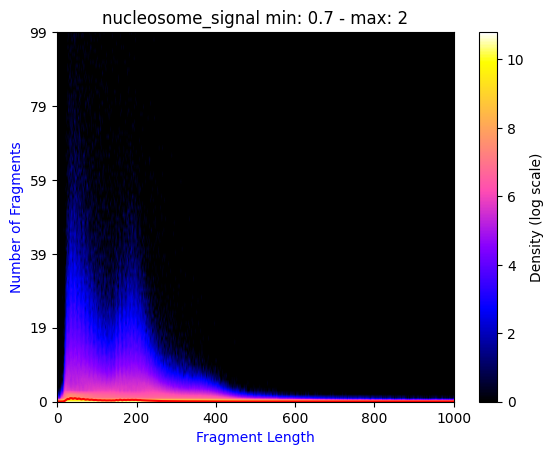

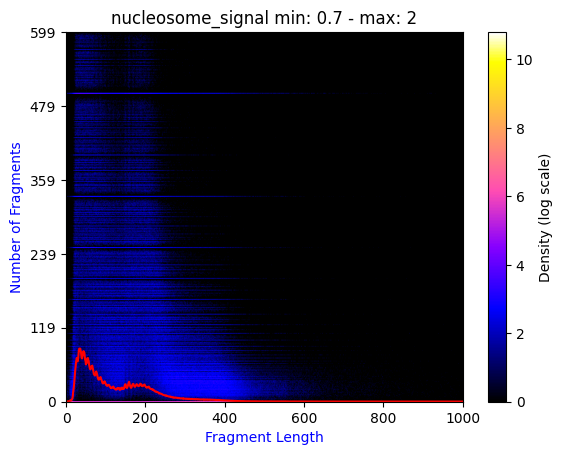

Count insertsizes from fragments...
Starting counting fragments...


Processing Chunks: 8it [00:33,  4.24s/it]


Done reading file - elapsed time: 0:00:44
Converting counts to dataframe...
Done getting insertsizes from fragments!
3028


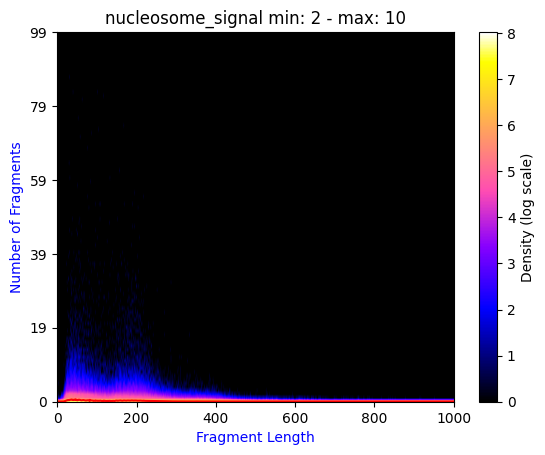

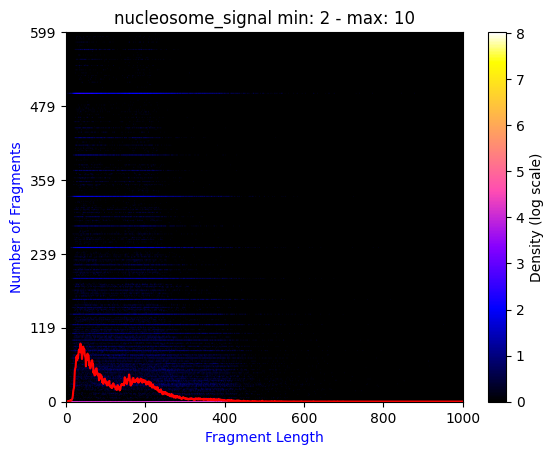

In [9]:
subsets = []
for key, value in thresholds.items():
    barcodes = list(adata.obs[np.logical_and(adata.obs[value['column']] >= value['min'], 
                                  adata.obs[value['column']] <= value['max'])].index)
    
    subsets.append(barcodes)
    
    count_table = ins.insertsize_from_fragments(fragments=fragments, barcodes=barcodes)
    dists_arr = np.array(count_table['dist'].tolist(), dtype=np.int64)
    print(len(barcodes))
    title=value['column'] + ' min: '+ str(value['min']) + ' - max: '+ str(value['max'])
    density_plot(dists_arr, colormap='gnuplot2', title=title, max_abundance=100)
    density_plot(fld.scale(dists_arr), colormap='gnuplot2', title=title)

In [10]:
"""HELPER FUNCTIONS."""
# Author: Jan Detleffsen (jan.detleffsen@mpi-bn.mpg.de)

import numpy as np
from tqdm import tqdm
from multiprocessing import Pool, Manager
from functools import partial
from collections import OrderedDict
import time

def calculate_distances(adata, neighbours, cell_idx, highly_variable=False):
    """
    Calculate edited distances of the available features between a cell and its neighbours.
    The distance is normalized by the total counts of the features.

    Parameters
    ----------
    adata : AnnData
        Annotated data matrix.
    neighbours : np.array
        Array of indices of the neighbours.
    cell_idx : int
        Index of the cell.

    Returns
    -------
    float
        Mean of the normalized distances.
    """
    
    # calculate the distances of the features between the cell and its neighbours
    # if the number of neighbours is larger than 0
    if len(neighbours) > 0:
        if highly_variable:
            # calculate the total counts of the neighbours
            feature_counts = np.sum(adata.X[neighbours][:, adata.var.highly_variable], axis=1)
            # calculate the total counts of the cell
            cell_count = np.sum(adata.X[cell_idx][:, adata.var.highly_variable])
            # calculate the total counts of the features
            total_counts = feature_counts + cell_count
            # calculate the distances of the features
            distances = np.sum(abs(adata.X[neighbours][:, adata.var.highly_variable] - adata.X[cell_idx][:, adata.var.highly_variable].toarray()[0]), axis=1)
            # change distance when there no highly variable features to 1
            zeros = np.where(total_counts == 0)
            # set the distances to 1
            distances[zeros] = 1
            # set the total counts to 1
            total_counts[zeros] = 1

        else:
            # calculate the total counts of the neighbours
            feature_counts = np.sum(adata.X[neighbours], axis=1)
            # calculate the total counts of the cell
            cell_count = np.sum(adata.X[cell_idx].toarray(), axis=1)[0]
            # calculate the total counts of the features
            total_counts = feature_counts + cell_count
            # calculate the distances of the features
            distances = np.sum(abs(adata.X[neighbours] - adata.X[cell_idx].toarray()[0]), axis=1)

        # normalize the distances by the total counts
        corrected_distances = distances / total_counts
        # calculate the mean of the normalized distances
        distance = np.mean(corrected_distances)
    # if there are no neighbours, set the distance to 1
    else:
        distance = 1

    return distance


def define_reference_cells(embedding, cell_idx, distance=False, n_cells=20):
    """
    Define the neighbours of a cell based on the Euclidean distance in the embedding space.

    Parameters
    ----------
    embedding : np.array
        Array of the embedding coordinates.
    cell_idx : int
        Index of the cell.
    distance : float
        Maximum distance in the embedding space to consider a cell as a neighbour.

    Returns
    -------
    np.array
        Array of indices of the neighbours.
    """
    # extract the embedding coordinates of the cell
    cell_coordinates = embedding[cell_idx]
    # calculate the relative coordinates of the cell to all other cells
    relative_coordinates = embedding - cell_coordinates
    # calculate the distances of the cells to the cell
    distances = np.linalg.norm(relative_coordinates, axis=1)
    # find the indices of the cells that are closer than the distance
    if distance:
        # define the neighbours based on the distance
        indices_neighbours = np.array(np.where(distances <= distance))
        # define number of cells tom select
        n_cells = len(indices_neighbours)
        # define most distant cells
        foreigners = np.argsort(distances)[-(n_cells-1):]
    else:
        # define the neighbours based on the number of cells to consider
        indices_neighbours = np.argsort(distances)[:n_cells]
        # define most distant cells
        foreigners = np.argsort(distances)[-(n_cells-1):] # -1 to correct for seeding cell
    # remove the cell itself from the indices
    neighbours = indices_neighbours[np.where(indices_neighbours != cell_idx)]

    return neighbours, foreigners


def add_similarity(adata, distance=False, n_cells=20, embedding=None, threads=1, chunksize=50, highly_variable=False):
    """
    Add the similarity of the cells to the AnnData object.

    The similarity is calculated as the mean of the normalized distances of the available features between a cell and its neighbours.

    Parameters
    ----------
    adata : AnnData
        Annotated data matrix.
    distance : float
        Maximum distance in the embedding space to consider a cell as a neighbour.
    embedding : str, optional
        Key of the embedding coordinates in adata.obsm. If None, the UMAP coordinates are used. Default is None.
    threads : int, optional
        Number of threads to use for the calculation. Default is 1.
    chunksize : int, optional
        Number of cells to process in one chunk. Default is 50.

    Returns
    -------
    None
    """
    # extract the embedding coordinates
    if embedding is None:
        coordinates = adata.obsm['X_umap']
    else:
        coordinates = adata.obsm[embedding]

    # check if highly variable features are available
    if 'highly_variable' not in adata.var.keys():
        highly_variable = False

    # initialize the Pool with the number of threads and the maximum number of tasks per child
    pool = Pool(processes=threads, maxtasksperchild=threads)
    # initialize a Manager to share the results between the processes
    manager = Manager()
    # initialize a dictionary to store the similarities
    similarities = manager.dict()

    # initialize a list to store the results of the processes
    async_results = []
    # initialize a list to build the chunks
    chunk = []

    # Calculate total number of chunks for progress bar
    total_chunks = (len(coordinates) + chunksize - 1) // chunksize  # rounds up
    pbar = tqdm(total=total_chunks, desc="Computing chunks")

    # iterate over the cells in the embedding
    for cell_idx, cell_coordinates in enumerate(coordinates):
        # append the cell index and the embedding coordinates to the chunk
        chunk.append([cell_idx, cell_coordinates])
        # if the chunk is full
        if len(chunk) == chunksize:
            # process the chunk
            result = pool.apply_async(process_chunk, args=(chunk, distance, n_cells, adata, coordinates, highly_variable),
                                      callback=partial(collect_result, similarities))
            # append the result to the list
            async_results.append(result)
            # clear the chunk
            chunk = []
            # update the progress bar
            pbar.update(1)
            # check if the number of running processes is larger than the number of threads
            while len(async_results) > 2 * threads:  # Adjust this ratio based on observed behavior and system specs
                # remove the finished processes
                async_results = [res for res in async_results if not res.ready()]
                # sleep for 1 second
                time.sleep(1)

    # remaining
    if len(chunk) != 0:
        result = pool.apply_async(process_chunk, args=(chunk, distance, n_cells, adata, coordinates, highly_variable),
                                  callback=partial(collect_result, similarities))
        async_results.append(result)
        pbar.update(1)

    for result in async_results:
        result.wait()

    pool.close()
    pool.join()

    similarities = dict(similarities)

    sorted_similarities = OrderedDict(sorted(similarities.items()))

    adata.obs['distance_score'] = np.fromiter(sorted_similarities.values(), dtype=float)


def collect_result(similarities, result):
    similarities.update(result)


def process_chunk(chunk, distance, n_cells, adata, coordinates, highly_variable=False):
    """
    process a chunk of cells to calculate the distance_score of the cells to their neighbours

    Parameters
    ----------
    chunk : list
        List of the cell indices and the embedding coordinates.
    distance : float
        Maximum distance in the embedding space to consider a cell as a neighbour.
    adata : AnnData
        Annotated data matrix.
    coordinates : np.array
        Array of the embedding coordinates.

    Returns
    -------
    dict
        Dictionary of the similarities.

    """
    sim_dict = {}
    for cell_idx, cell_coordinates in chunk:
        # define the reference cells
        neighbours, foreigners = define_reference_cells(coordinates, cell_idx, distance, n_cells)
        # calculate the distances of the features between the cell and its neighbours
        distance_n = calculate_distances(adata, neighbours, cell_idx, highly_variable=highly_variable)
        # calculate the distances of the features between the cell and the most distant cells
        distance_f = calculate_distances(adata, foreigners, cell_idx, highly_variable=highly_variable)
        # calculate the distance based score of the cell
        sim_dict[cell_idx] = 1/(distance_f+1) + distance_n

    return sim_dict


#define function to calculate Gini coefficient
def gini(x):
    total = 0
    for i, xi in enumerate(x[:-1], 1):
        total += np.sum(np.abs(xi - x[i:]))
    return total / (len(x)**2 * np.mean(x))


def calc_agi(adata, condition_column='cell_types_leiden_0.4'):
    
    adata_copy = adata.copy()
    conditions = adata_copy.obs[condition_column].unique()
    enrichment_columns = []

    for cond in conditions:

        # slice by cluster 
        adata_slice = adata_copy.obs_names[adata_copy.obs[condition_column] == str(cond)]
        subdata = adata_copy[adata_slice, :]
        # select all peaks available in the cluster 
        genes = subdata.var[subdata.layers['binary'].sum(axis=0).A1 > 1]
        # count abundances
        gene_counts = subdata.layers['binary'].sum(axis=0).A1[subdata.layers['binary'].sum(axis=0).A1 > 1]
        genes.loc[:, 'cluster_counts_' + str(cond)] = gene_counts
        # calc enrichment 
        genes['enrichment_' + str(cond)] = genes['cluster_counts_' + str(cond)] / genes['total_counts']
        # remove old tables
        # join results
        adata_copy.var = adata_copy.var.join(genes['cluster_counts_' + str(cond)])
        adata_copy.var = adata_copy.var.join(genes['enrichment_' + str(cond)])

        enrichment_columns.append('enrichment_' + str(cond))

    enrichments = adata_copy.var[enrichment_columns].values
    enrichments[np.isnan(enrichments)] = 0

    gini_coefficients = []
    for enrichment in enrichments:
        gini_coefficients.append(gini(enrichment))

    adata_copy.var[condition_column + '_' + 'gini'] = gini_coefficients

    return adata_copy

In [11]:
# Removal of feature subsets
filter_chrM = True  # True or False; filtering out chrM
filter_xy = True    # True or False; filtering out chrX and chrY

# Highly Variable Features options 
select_highly_variable = True
min_cells = 5 # This one is mandatory
max_cells = None

# Choose normalization method
# TF-IDF: dimensionality is reduced by LSI
# Total: dimensionality is reduced by PCA 
norm_method = 'tfidf'  # can be 'tfidf' or 'total'

# Choose if highly variable features should be used
use_highly_variable = True

# Set number of neighbors
n_neighbors = 15

# UMAP related settings 
metacol = 'sample'  # some meta-column of interest. See tables above.
n_features = 'n_features'  # column name for the number of features. See tables above.

# number of PCs shown within the heatmap
n_pcs_heatmap = 30

# Whether PCs should be filtered
subset_pcs = True

corr_thresh = 0.70  # PCs with an absolut correlation above this will be filtered
perc_thresh = 30  # Top percentile of PCs that should be kept
filter_methods = ['cumulative variance', 'correlation']  # propose PCs based on the provided methods
basis = 'obs'  # base correlation on obs or var
ignore_cols = []  # List of column names to ignore for correlation

# Final choice of spread / dist for umap
min_dist = 0.3
spread = 1.0

n_components = 2

In [12]:
# Recalculate standard QC metrics (counts...)
adata = tools.qc_filter.calculate_qc_metrics(adata, var_type='features')

# drop total_counts as it is the same as n_features
adata.obs.drop(columns=["total_counts", "log1p_total_counts"], inplace=True)

# Remove peaks with 0 count
zero_bool = adata.var["n_cells_by_counts"] == 0
adata = adata[:,~zero_bool]

In [13]:
full_adata = adata.copy()

In [15]:
full_adata[np.logical_and(full_adata.obs[value['column']] >= value['min'], 
                   full_adata.obs[value['column']] <= value['max'])].copy()

AnnData object with n_obs × n_vars = 3028 × 101651
    obs: 'TN', 'UM', 'PP', 'UQ', 'CM', 'file', 'sample', 'nucleosome_signal', 'fld_score', 'mean_fragment_size', 'n_fragments', 'fold_change_promoters_fragments', 'frip', 'tsse_score', 'catlas_ov', 'cell type', 'n_features', 'log1p_n_features'
    var: 'peak_chr', 'peak_start', 'peak_end', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts'
    uns: 'files', 'sctoolbox'

# Process subsets and compute UMAPs

-----------------------
metric: fld_score
min: 0
max: --
-----------------------


AnnData object with n_obs × n_vars = 69042 × 101651
    obs: 'TN', 'UM', 'PP', 'UQ', 'CM', 'file', 'sample', 'nucleosome_signal', 'fld_score', 'mean_fragment_size', 'n_fragments', 'fold_change_promoters_fragments', 'frip', 'tsse_score', 'catlas_ov', 'cell type', 'n_features', 'log1p_n_features'
    var: 'peak_chr', 'peak_start', 'peak_end', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts'
    uns: 'files', 'sctoolbox'

TN      UM      PP      UQ     CM  \
barcode                                                         
AAACTACCAGAAACCCGAGATA    28.0    21.0    21.0    21.0    1.0   
AAACTACCAGAAACCTAAGTGG  7116.0  6025.0  6011.0  6011.0  218.0   
AAACTACCAGAAACGGATCAGT  3692.0  3009.0  3004.0  3004.0   69.0   
AAACTACCAGAAACGTCCCGTT    21.0    19.0    19.0    19.0    0.0   
AAACTACCAGAAACTAGCCCTA    22.0    19.0    19.0    19.0    2.0   
...                        ...     ...     ...     ...    ...   
TTCCATCCTCTTTCGAAGAAGG   721.0   600.0   598.0   598.0  153.0   
TTCCATCCTCTTTCGCGTGTAA     4.0     4.0     4.0     4.0    0.0   
TTCCATCCTCTTTCTGCAGACT   584.0   506.0   506.0   506.0   27.0   
TTCCATCCTCTTTGCCGGAAGG     5.0     5.0     5.0     5.0    0.0   
TTCCATCCTCTTTGTGTTACCG   629.0   518.0   517.0   517.0   39.0   

                                                                     file  \
barcode                                                                     
AAACTACCAGAAACCCGAGATA  /mnt/workspace2/jdetlef/peakqc_paperprep/bench...   
AAACTACCAGAAACCTAAGTGG  /mnt/workspace2/jdetlef/peakqc_paperprep/bench...   
AAACTACCAGAAACGGATCAGT  /mnt/workspace2/jdetlef/peakqc_paperprep/bench...   
AAACTACCAGAAACGTCCCGTT  /mnt/workspace2/jdetlef/peakqc_paperprep/bench...   
AAACTACCAGAAACTAGCCCTA  /mnt/workspace2/jdetlef/peakqc_paperprep/bench...   
...                                                                   ...   
TTCCATCCTCTTTCGAAGAAGG  /mnt/workspace2/jdetlef/peakqc_paperprep/bench...   
TTCCATCCTCTTTCGCGTGTAA  /mnt/workspace2/jdetlef/peakqc_paperprep/bench...   
TTCCATCCTCTTTCTGCAGACT  /mnt/workspace2/jdetlef/peakqc_paperprep/bench...   
TTCCATCCTCTTTGCCGGAAGG  /mnt/workspace2/jdetlef/peakqc_paperprep/bench...   
TTCCATCCTCTTTGTGTTACCG  /mnt/workspace2/jdetlef/peakqc_paperprep/bench...   

                       sample  nucleosome_signal   fld_score  \
barcode                                                        
AAACTACCAGAAACCCGAGATA     MB           1.000000    0.003301   
AAACTACCAGAAACCTAAGTGG     MB           0.434524  305.939935   
AAACTACCAGAAACGGATCAGT     MB           0.462500  184.560884   
AAACTACCAGAAACGTCCCGTT     MB           1.000000    3.400717   
AAACTACCAGAAACTAGCCCTA     MB           1.000000   10.770080   
...                       ...                ...         ...   
TTCCATCCTCTTTCGAAGAAGG     MB           1.000000   76.517145   
TTCCATCCTCTTTCGCGTGTAA     MB           1.000000    0.128179   
TTCCATCCTCTTTCTGCAGACT     MB           0.421053   58.356201   
TTCCATCCTCTTTGCCGGAAGG     MB           1.000000    0.053747   
TTCCATCCTCTTTGTGTTACCG     MB           0.294118   40.761008   

                        mean_fragment_size  n_fragments  \
barcode                                                   
AAACTACCAGAAACCCGAGATA              117.23         13.0   
AAACTACCAGAAACCTAAGTGG              132.91       5861.0   
AAACTACCAGAAACGGATCAGT              137.64       2933.0   
AAACTACCAGAAACGTCCCGTT               79.43         20.0   
AAACTACCAGAAACTAGCCCTA              119.23         24.0   
...                                    ...          ...   
TTCCATCCTCTTTCGAAGAAGG              148.31        530.0   
TTCCATCCTCTTTCGCGTGTAA               44.40          5.0   
TTCCATCCTCTTTCTGCAGACT              129.30        520.0   
TTCCATCCTCTTTGCCGGAAGG              135.67          3.0   
TTCCATCCTCTTTGTGTTACCG              137.91        487.0   

                        fold_change_promoters_fragments      frip  tsse_score  \
barcode                                                                         
AAACTACCAGAAACCCGAGATA                         0.076923  0.384615    1.000000   
AAACTACCAGAAACCTAAGTGG                         0.163795  0.112779    1.513383   
AAACTACCAGAAACGGATCAGT                         0.171838  0.086260    1.208600   
AAACTACCAGAAACGTCCCGTT                         0.250000  0.200000    0.000000   
AAACTACCAGAAACTAGCCCTA                         0.041667  0.250000    0.000000   
...         

peak_chr  peak_start  peak_end  n_cells_by_counts  \
name                                                                       
chr1:10007-10565           chr1       10007     10565                 59   
chr1:28992-29433           chr1       28992     29433                 13   
chr1:136833-136999         chr1      136833    136999                  1   
chr1:180705-181054         chr1      180705    181054                 54   
chr1:181132-181985         chr1      181132    181985                 71   
...                         ...         ...       ...                ...   
chrY:56850348-56850516     chrY    56850348  56850516                114   
chrY:56850724-56850993     chrY    56850724  56850993                274   
chrY:56851055-56851204     chrY    56851055  56851204                 94   
chrY:56870833-56870955     chrY    56870833  56870955                 55   
chrY:56886632-56886906     chrY    56886632  56886906                 15   

                        mean_counts  log1p_mean_counts  pct_dropout_by_counts  \
name                                                                            
chr1:10007-10565           0.000849           0.000849              99.915072   
chr1:28992-29433           0.000187           0.000187              99.981287   
chr1:136833-136999         0.000014           0.000014              99.998561   
chr1:180705-181054         0.000806           0.000806              99.922270   
chr1:181132-181985         0.001022           0.001021              99.897799   
...                             ...                ...                    ...   
chrY:56850348-56850516     0.001684           0.001683              99.835903   
chrY:56850724-56850993     0.004045           0.004037              99.605591   
chrY:56851055-56851204     0.001367           0.001367              99.864692   
chrY:56870833-56870955     0.000835           0.000835              99.920830   
chrY:56886632-56886906     0.000216           0.000216              99.978408   

                        total_counts  log1p_total_counts  
name                                                      
chr1:10007-10565                59.0            4.094345  
chr1:28992-29433                13.0            2.639057  
chr1:136833-136999               1.0            0.693147  
chr1:180705-181054              56.0            4.043051  
chr1:181132-181985              71.0            4.276666  
...                              ...                 ...  
chrY:56850348-56850516         117.0            4.770685  
chrY:56850724-56850993         281.0            5.641907  
chrY:56851055-56851204          95.0            4.564348  
chrY:56870833-56870955          58.0            4.077538  
chrY:56886632-56886906          15.0            2.772589  

[101651 rows x 9 columns]

Removing chromosomal features...
Removing gender related features...


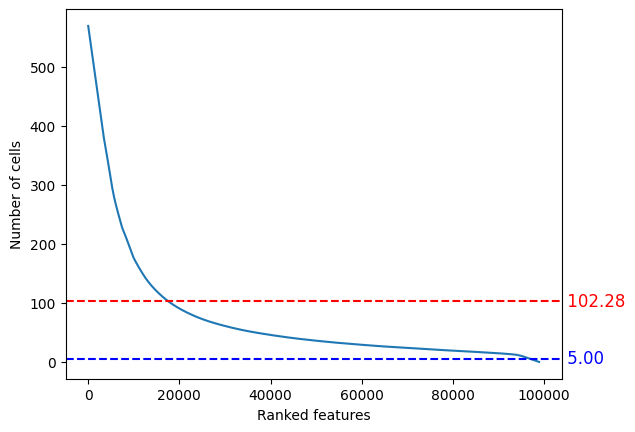

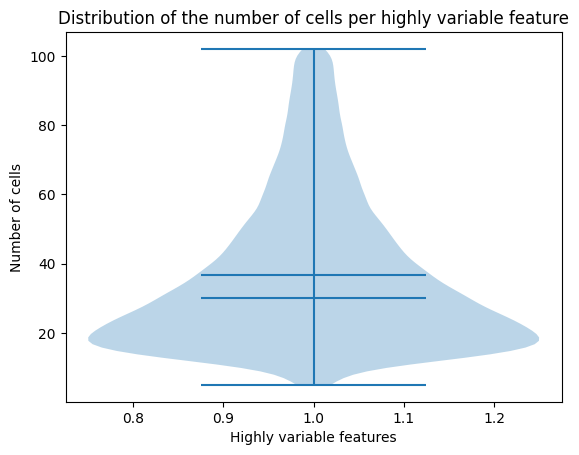

[INFO] Performing TFIDF and LSI...


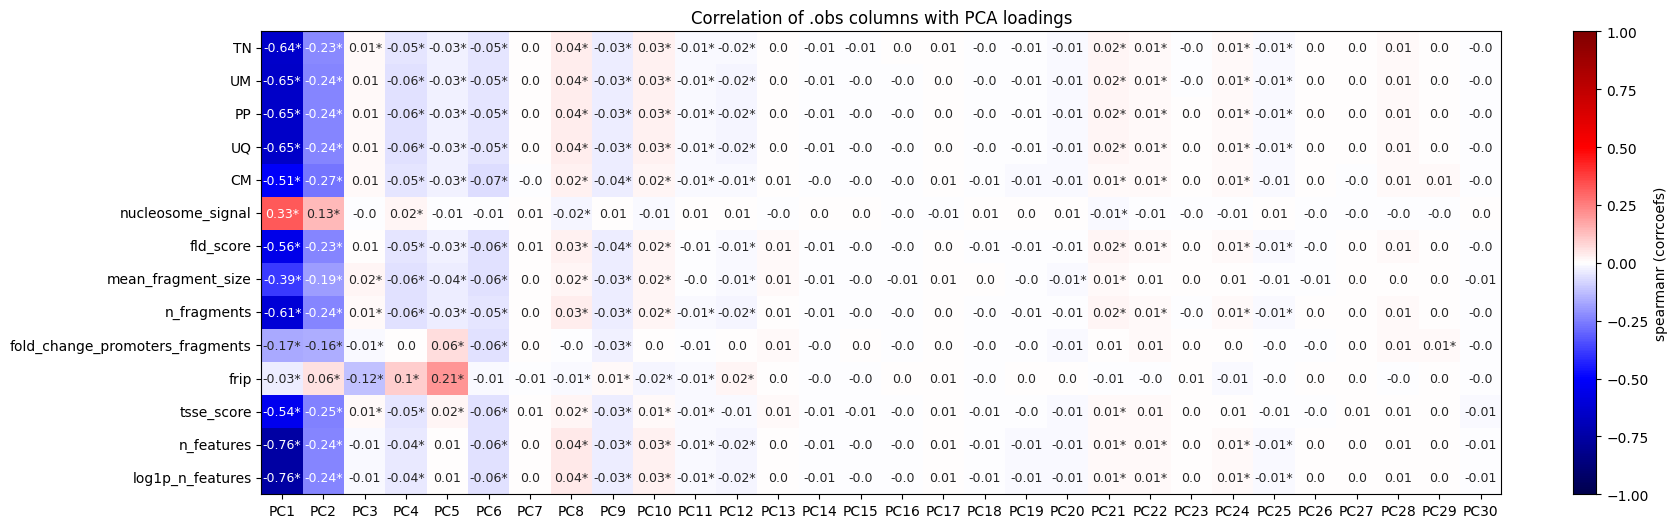

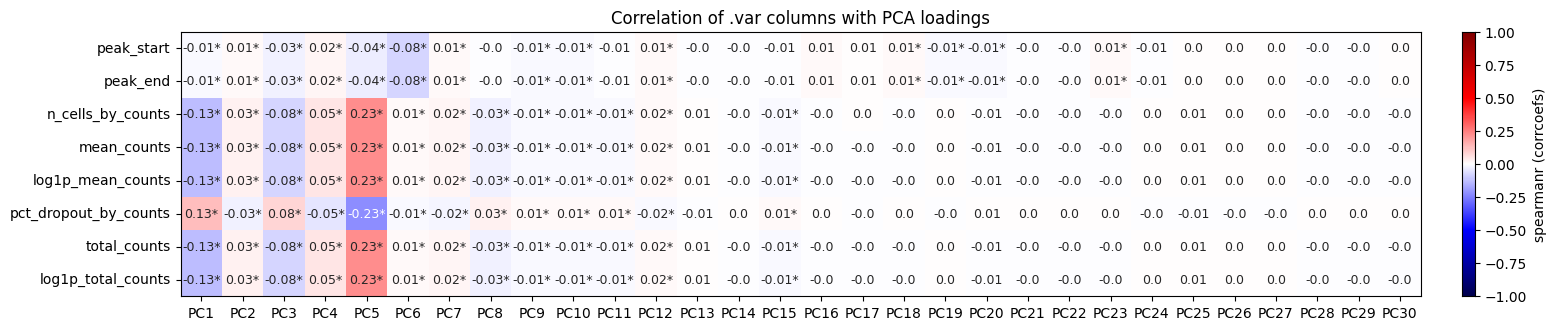

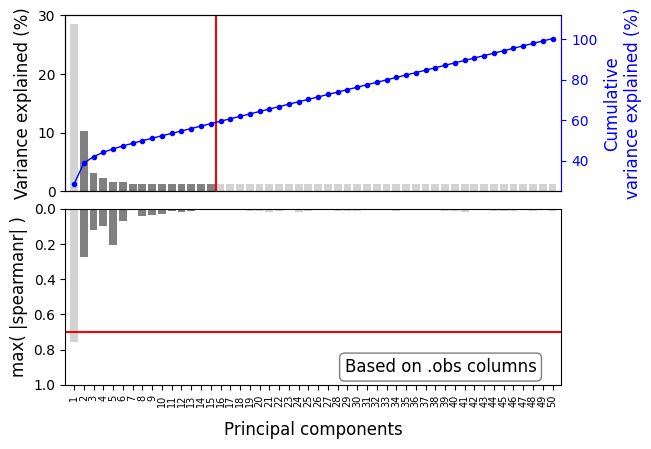

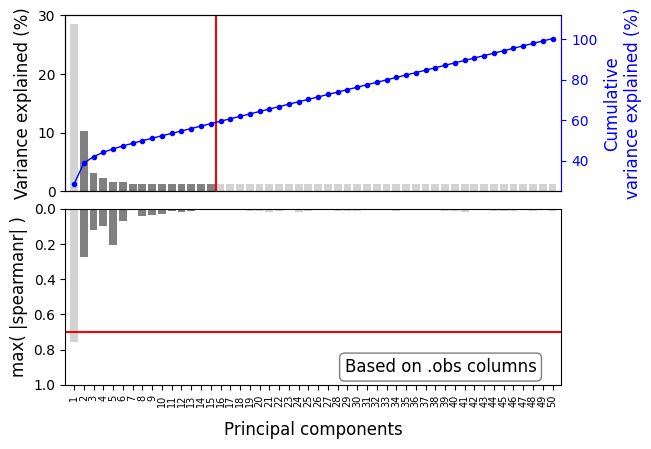

Computing chunks:   8%|▊         | 109/1381 [01:06<17:09,  1.24it/s]Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Computing chunks:   8%|▊         | 111/1381 [01:07<15:08,  1.40it/s]Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Computing chunks:   8%|▊         | 116/1381 [01:10<11:22,  1.85it/s]Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process

Computing chunks:  45%|████▍     | 616/1381 [06:01<07:14,  1.76it/s]Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Computing chunks:  51%|█████▏    | 709/1381 [06:57<07:00,  1.60it/s]Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Computing chunks:  52%|█████▏    | 718/1381 [07:02<05:46,  1.92it/s]Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process

Computing chunks:  88%|████████▊ | 1220/1381 [11:51<01:44,  1.54it/s]Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Computing chunks:  95%|█████████▌| 1317/1381 [12:45<00:28,  2.24it/s]Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Computing chunks: 100%|██████████| 1381/1381 [13:35<00:00,  1.69it/s]


Embedding quality by the distance score: 1.5


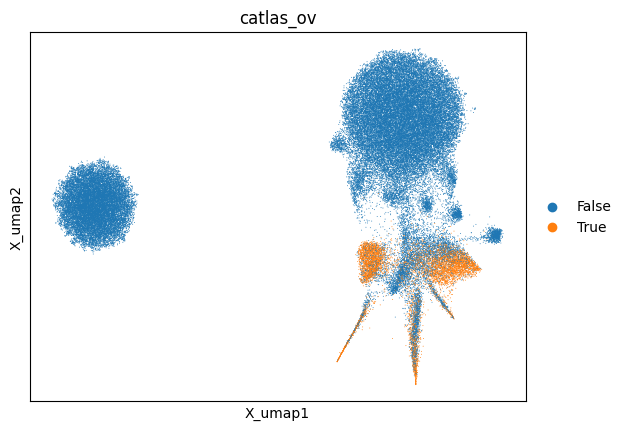

-----------------------
metric: fld_score
min: 100
max: --
-----------------------


AnnData object with n_obs × n_vars = 10316 × 101651
    obs: 'TN', 'UM', 'PP', 'UQ', 'CM', 'file', 'sample', 'nucleosome_signal', 'fld_score', 'mean_fragment_size', 'n_fragments', 'fold_change_promoters_fragments', 'frip', 'tsse_score', 'catlas_ov', 'cell type', 'n_features', 'log1p_n_features'
    var: 'peak_chr', 'peak_start', 'peak_end', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts'
    uns: 'files', 'sctoolbox'

TN      UM      PP      UQ     CM  \
barcode                                                         
AAACTACCAGAAACCTAAGTGG  7116.0  6025.0  6011.0  6011.0  218.0   
AAACTACCAGAAACGGATCAGT  3692.0  3009.0  3004.0  3004.0   69.0   
AAACTACCAGAAATAAGGCCAG  7244.0  6422.0  6403.0  6403.0  113.0   
AAACTACCAGAACATGAAGCGC  1895.0  1654.0  1649.0  1649.0   71.0   
AAACTACCAGAACCGAATTCTC  4864.0  4390.0  4381.0  4381.0  168.0   
...                        ...     ...     ...     ...    ...   
TTCCATCCTCTGCTAGCCTATA  1498.0  1140.0  1138.0  1138.0  149.0   
TTCCATCCTCTGGGCACATTAG  1553.0  1235.0  1233.0  1233.0  106.0   
TTCCATCCTCTGGTGAGGTGAT  8161.0  6995.0  6977.0  6977.0  127.0   
TTCCATCCTCTTAGTGCTAGCA  4475.0  3875.0  3866.0  3867.0  292.0   
TTCCATCCTCTTGAGTGCTGTG  1122.0   993.0   990.0   990.0   35.0   

                                                                     file  \
barcode                                                                     
AAACTACCAGAAACCTAAGTGG  /mnt/workspace2/jdetlef/peakqc_paperprep/bench...   
AAACTACCAGAAACGGATCAGT  /mnt/workspace2/jdetlef/peakqc_paperprep/bench...   
AAACTACCAGAAATAAGGCCAG  /mnt/workspace2/jdetlef/peakqc_paperprep/bench...   
AAACTACCAGAACATGAAGCGC  /mnt/workspace2/jdetlef/peakqc_paperprep/bench...   
AAACTACCAGAACCGAATTCTC  /mnt/workspace2/jdetlef/peakqc_paperprep/bench...   
...                                                                   ...   
TTCCATCCTCTGCTAGCCTATA  /mnt/workspace2/jdetlef/peakqc_paperprep/bench...   
TTCCATCCTCTGGGCACATTAG  /mnt/workspace2/jdetlef/peakqc_paperprep/bench...   
TTCCATCCTCTGGTGAGGTGAT  /mnt/workspace2/jdetlef/peakqc_paperprep/bench...   
TTCCATCCTCTTAGTGCTAGCA  /mnt/workspace2/jdetlef/peakqc_paperprep/bench...   
TTCCATCCTCTTGAGTGCTGTG  /mnt/workspace2/jdetlef/peakqc_paperprep/bench...   

                       sample  nucleosome_signal    fld_score  \
barcode                                                         
AAACTACCAGAAACCTAAGTGG     MB           0.434524   305.939935   
AAACTACCAGAAACGGATCAGT     MB           0.462500   184.560884   
AAACTACCAGAAATAAGGCCAG     MB           0.526786  1110.717402   
AAACTACCAGAACATGAAGCGC     MB           0.653846   171.855951   
AAACTACCAGAACCGAATTCTC     MB           0.339806   567.822923   
...                       ...                ...          ...   
TTCCATCCTCTGCTAGCCTATA     MB           0.500000   132.282873   
TTCCATCCTCTGGGCACATTAG     MB           0.470588   118.560913   
TTCCATCCTCTGGTGAGGTGAT     MB           0.437086   760.310800   
TTCCATCCTCTTAGTGCTAGCA     MB           0.481013   391.046807   
TTCCATCCTCTTGAGTGCTGTG     MB           0.200000   128.721497   

                        mean_fragment_size  n_fragments  \
barcode                                                   
AAACTACCAGAAACCTAAGTGG              132.91       5861.0   
AAACTACCAGAAACGGATCAGT              137.64       2933.0   
AAACTACCAGAAATAAGGCCAG              139.16       6615.0   
AAACTACCAGAACATGAAGCGC              145.87       1592.0   
AAACTACCAGAACCGAATTCTC              123.41       4205.0   
...                                    ...          ...   
TTCCATCCTCTGCTAGCCTATA              134.22       1140.0   
TTCCATCCTCTGGGCACATTAG              124.75       1117.0   
TTCCATCCTCTGGTGAGGTGAT              121.68       6477.0   
TTCCATCCTCTTAGTGCTAGCA              132.70       3816.0   
TTCCATCCTCTTGAGTGCTGTG              129.88        987.0   

                        fold_change_promoters_fragments      frip  tsse_score  \
barcode                                                                         
AAACTACCAGAAACCTAAGTGG                         0.163795  0.112779    1.513383   
AAACTACCAGAAACGGATCAGT                         0.171838  0.086260    1.208600   
AAACTACCAGAAATAAGGCCAG                         0.355502  0.414752    3.795517   
AAACTACCAGAACATGAAGCGC                         0.291457  0.194095    1.574153   
AAACTACCAGAACCGAATTCTC                         0.336504  0.373841    4.055779   

peak_chr  peak_start  peak_end  n_cells_by_counts  \
name                                                                       
chr1:10007-10565           chr1       10007     10565                 59   
chr1:28992-29433           chr1       28992     29433                 13   
chr1:136833-136999         chr1      136833    136999                  1   
chr1:180705-181054         chr1      180705    181054                 54   
chr1:181132-181985         chr1      181132    181985                 71   
...                         ...         ...       ...                ...   
chrY:56850348-56850516     chrY    56850348  56850516                114   
chrY:56850724-56850993     chrY    56850724  56850993                274   
chrY:56851055-56851204     chrY    56851055  56851204                 94   
chrY:56870833-56870955     chrY    56870833  56870955                 55   
chrY:56886632-56886906     chrY    56886632  56886906                 15   

                        mean_counts  log1p_mean_counts  pct_dropout_by_counts  \
name                                                                            
chr1:10007-10565           0.000849           0.000849              99.915072   
chr1:28992-29433           0.000187           0.000187              99.981287   
chr1:136833-136999         0.000014           0.000014              99.998561   
chr1:180705-181054         0.000806           0.000806              99.922270   
chr1:181132-181985         0.001022           0.001021              99.897799   
...                             ...                ...                    ...   
chrY:56850348-56850516     0.001684           0.001683              99.835903   
chrY:56850724-56850993     0.004045           0.004037              99.605591   
chrY:56851055-56851204     0.001367           0.001367              99.864692   
chrY:56870833-56870955     0.000835           0.000835              99.920830   
chrY:56886632-56886906     0.000216           0.000216              99.978408   

                        total_counts  log1p_total_counts  
name                                                      
chr1:10007-10565                59.0            4.094345  
chr1:28992-29433                13.0            2.639057  
chr1:136833-136999               1.0            0.693147  
chr1:180705-181054              56.0            4.043051  
chr1:181132-181985              71.0            4.276666  
...                              ...                 ...  
chrY:56850348-56850516         117.0            4.770685  
chrY:56850724-56850993         281.0            5.641907  
chrY:56851055-56851204          95.0            4.564348  
chrY:56870833-56870955          58.0            4.077538  
chrY:56886632-56886906          15.0            2.772589  

[101651 rows x 9 columns]

Removing chromosomal features...
Removing gender related features...


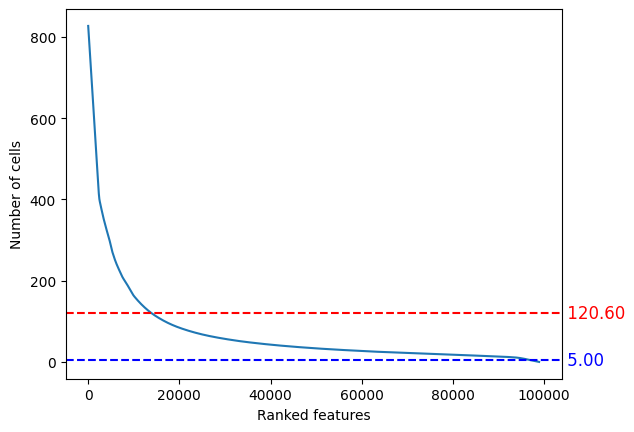

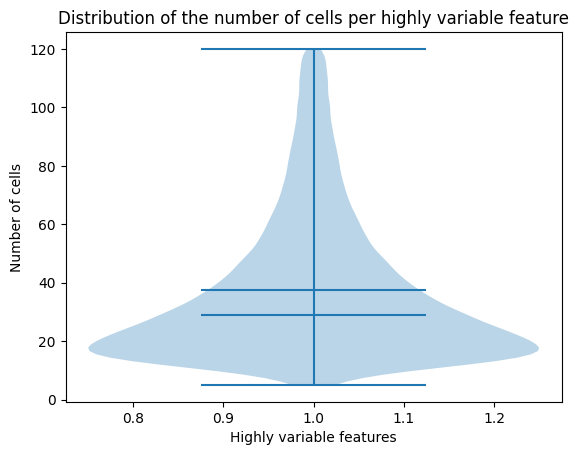

[INFO] Performing TFIDF and LSI...


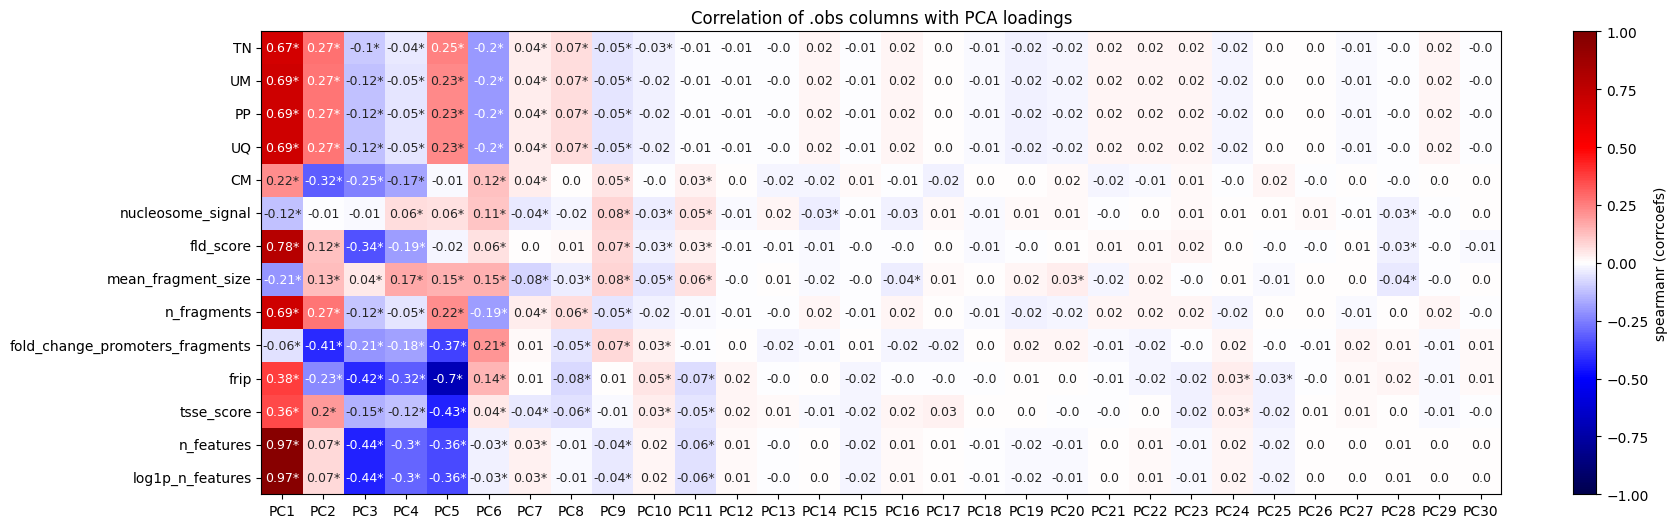

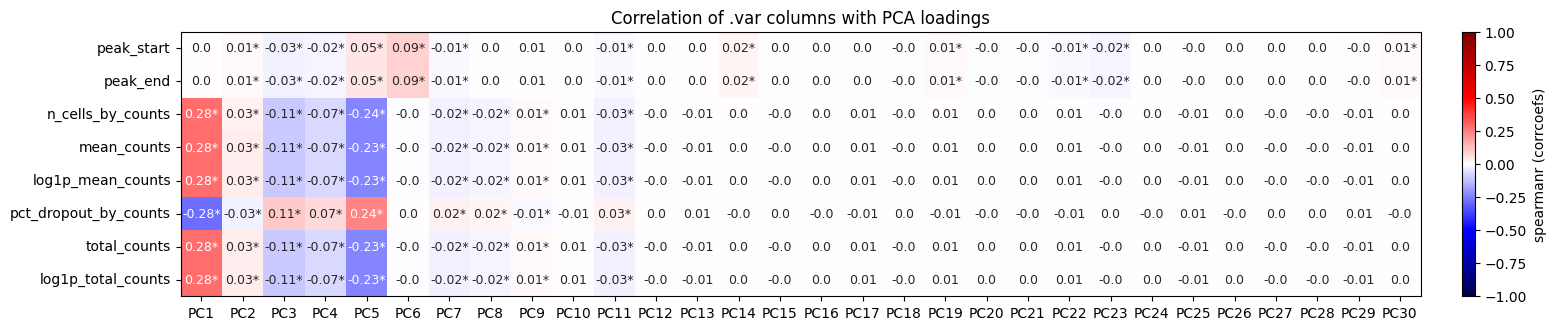

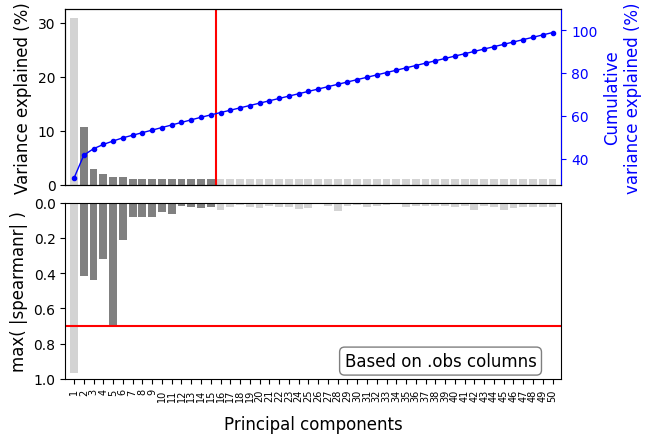

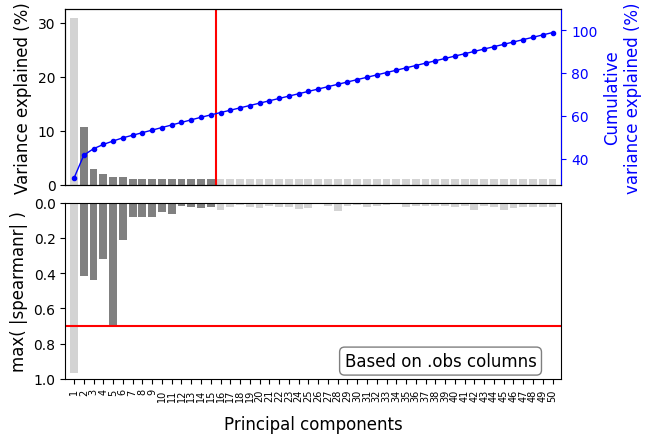

Computing chunks:  52%|█████▏    | 107/207 [00:34<00:33,  3.00it/s]Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Computing chunks:  54%|█████▎    | 111/207 [00:35<00:29,  3.22it/s]Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Computing chunks:  55%|█████▍    | 113/207 [00:36<00:35,  2.68it/s]N

Embedding quality by the distance score: 1.4952013867502911


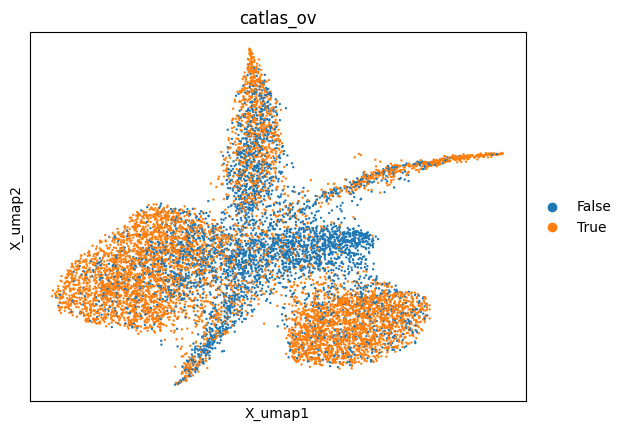

-----------------------
metric: fld_score
min: 200
max: --
-----------------------


AnnData object with n_obs × n_vars = 6661 × 101651
    obs: 'TN', 'UM', 'PP', 'UQ', 'CM', 'file', 'sample', 'nucleosome_signal', 'fld_score', 'mean_fragment_size', 'n_fragments', 'fold_change_promoters_fragments', 'frip', 'tsse_score', 'catlas_ov', 'cell type', 'n_features', 'log1p_n_features'
    var: 'peak_chr', 'peak_start', 'peak_end', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts'
    uns: 'files', 'sctoolbox'

TN      UM      PP      UQ     CM  \
barcode                                                         
AAACTACCAGAAACCTAAGTGG  7116.0  6025.0  6011.0  6011.0  218.0   
AAACTACCAGAAATAAGGCCAG  7244.0  6422.0  6403.0  6403.0  113.0   
AAACTACCAGAACCGAATTCTC  4864.0  4390.0  4381.0  4381.0  168.0   
AAACTACCAGAACTGCGTCTTT  2764.0  2471.0  2465.0  2465.0   69.0   
AAACTACCAGAACTTCGACCAG  1924.0  1713.0  1703.0  1703.0  218.0   
...                        ...     ...     ...     ...    ...   
TTCCATCCTCTCTTTGACGCTG  1175.0  1022.0  1020.0  1020.0  122.0   
TTCCATCCTCTGCAGAACAGTG  2995.0  2502.0  2493.0  2493.0  227.0   
TTCCATCCTCTGCGTCGAGTAC  4424.0  3782.0  3770.0  3770.0  310.0   
TTCCATCCTCTGGTGAGGTGAT  8161.0  6995.0  6977.0  6977.0  127.0   
TTCCATCCTCTTAGTGCTAGCA  4475.0  3875.0  3866.0  3867.0  292.0   

                                                                     file  \
barcode                                                                     
AAACTACCAGAAACCTAAGTGG  /mnt/workspace2/jdetlef/peakqc_paperprep/bench...   
AAACTACCAGAAATAAGGCCAG  /mnt/workspace2/jdetlef/peakqc_paperprep/bench...   
AAACTACCAGAACCGAATTCTC  /mnt/workspace2/jdetlef/peakqc_paperprep/bench...   
AAACTACCAGAACTGCGTCTTT  /mnt/workspace2/jdetlef/peakqc_paperprep/bench...   
AAACTACCAGAACTTCGACCAG  /mnt/workspace2/jdetlef/peakqc_paperprep/bench...   
...                                                                   ...   
TTCCATCCTCTCTTTGACGCTG  /mnt/workspace2/jdetlef/peakqc_paperprep/bench...   
TTCCATCCTCTGCAGAACAGTG  /mnt/workspace2/jdetlef/peakqc_paperprep/bench...   
TTCCATCCTCTGCGTCGAGTAC  /mnt/workspace2/jdetlef/peakqc_paperprep/bench...   
TTCCATCCTCTGGTGAGGTGAT  /mnt/workspace2/jdetlef/peakqc_paperprep/bench...   
TTCCATCCTCTTAGTGCTAGCA  /mnt/workspace2/jdetlef/peakqc_paperprep/bench...   

                       sample  nucleosome_signal    fld_score  \
barcode                                                         
AAACTACCAGAAACCTAAGTGG     MB           0.434524   305.939935   
AAACTACCAGAAATAAGGCCAG     MB           0.526786  1110.717402   
AAACTACCAGAACCGAATTCTC     MB           0.339806   567.822923   
AAACTACCAGAACTGCGTCTTT     MB           0.660714   347.744470   
AAACTACCAGAACTTCGACCAG     MB           0.566667   252.691346   
...                       ...                ...          ...   
TTCCATCCTCTCTTTGACGCTG     MB           0.466667   218.703618   
TTCCATCCTCTGCAGAACAGTG     MB           0.418182   222.135761   
TTCCATCCTCTGCGTCGAGTAC     MB           0.860000   772.765143   
TTCCATCCTCTGGTGAGGTGAT     MB           0.437086   760.310800   
TTCCATCCTCTTAGTGCTAGCA     MB           0.481013   391.046807   

                        mean_fragment_size  n_fragments  \
barcode                                                   
AAACTACCAGAAACCTAAGTGG              132.91       5861.0   
AAACTACCAGAAATAAGGCCAG              139.16       6615.0   
AAACTACCAGAACCGAATTCTC              123.41       4205.0   
AAACTACCAGAACTGCGTCTTT              134.55       2405.0   
AAACTACCAGAACTTCGACCAG              141.21       1681.0   
...                                    ...          ...   
TTCCATCCTCTCTTTGACGCTG              153.08        897.0   
TTCCATCCTCTGCAGAACAGTG              134.31       2325.0   
TTCCATCCTCTGCGTCGAGTAC              153.43       3363.0   
TTCCATCCTCTGGTGAGGTGAT              121.68       6477.0   
TTCCATCCTCTTAGTGCTAGCA              132.70       3816.0   

                        fold_change_promoters_fragments      frip  tsse_score  \
barcode                                                                         
AAACTACCAGAAACCTAAGTGG                         0.163795  0.112779    1.513383   
AAACTACCAGAAATAAGGCCAG                         0.355502  0.414752    3.795517   
AAACTACCAGAACCGAATTCTC                         0.336504  0.373841    4.055779   
AAACTACCAGAACTGCGTCTTT                         0.219127  0.299792    4.370927   
AAACTACCAGAACTTCGACCAG                         0.719121  0.510689    3.723404   

peak_chr  peak_start  peak_end  n_cells_by_counts  \
name                                                                       
chr1:10007-10565           chr1       10007     10565                 59   
chr1:28992-29433           chr1       28992     29433                 13   
chr1:136833-136999         chr1      136833    136999                  1   
chr1:180705-181054         chr1      180705    181054                 54   
chr1:181132-181985         chr1      181132    181985                 71   
...                         ...         ...       ...                ...   
chrY:56850348-56850516     chrY    56850348  56850516                114   
chrY:56850724-56850993     chrY    56850724  56850993                274   
chrY:56851055-56851204     chrY    56851055  56851204                 94   
chrY:56870833-56870955     chrY    56870833  56870955                 55   
chrY:56886632-56886906     chrY    56886632  56886906                 15   

                        mean_counts  log1p_mean_counts  pct_dropout_by_counts  \
name                                                                            
chr1:10007-10565           0.000849           0.000849              99.915072   
chr1:28992-29433           0.000187           0.000187              99.981287   
chr1:136833-136999         0.000014           0.000014              99.998561   
chr1:180705-181054         0.000806           0.000806              99.922270   
chr1:181132-181985         0.001022           0.001021              99.897799   
...                             ...                ...                    ...   
chrY:56850348-56850516     0.001684           0.001683              99.835903   
chrY:56850724-56850993     0.004045           0.004037              99.605591   
chrY:56851055-56851204     0.001367           0.001367              99.864692   
chrY:56870833-56870955     0.000835           0.000835              99.920830   
chrY:56886632-56886906     0.000216           0.000216              99.978408   

                        total_counts  log1p_total_counts  
name                                                      
chr1:10007-10565                59.0            4.094345  
chr1:28992-29433                13.0            2.639057  
chr1:136833-136999               1.0            0.693147  
chr1:180705-181054              56.0            4.043051  
chr1:181132-181985              71.0            4.276666  
...                              ...                 ...  
chrY:56850348-56850516         117.0            4.770685  
chrY:56850724-56850993         281.0            5.641907  
chrY:56851055-56851204          95.0            4.564348  
chrY:56870833-56870955          58.0            4.077538  
chrY:56886632-56886906          15.0            2.772589  

[101651 rows x 9 columns]

Removing chromosomal features...
Removing gender related features...


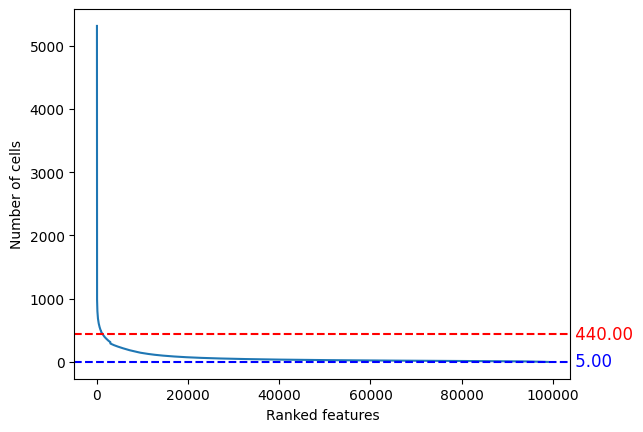

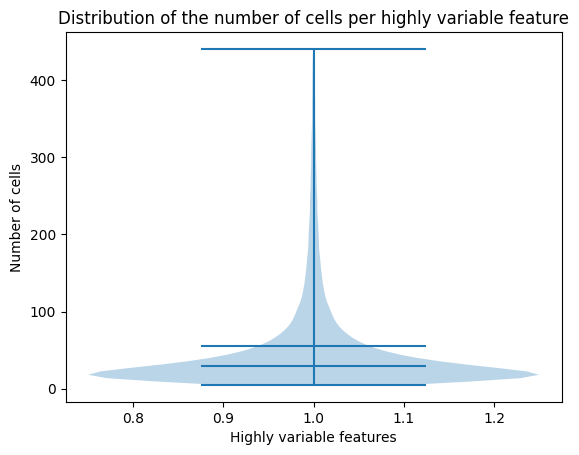

[INFO] Performing TFIDF and LSI...


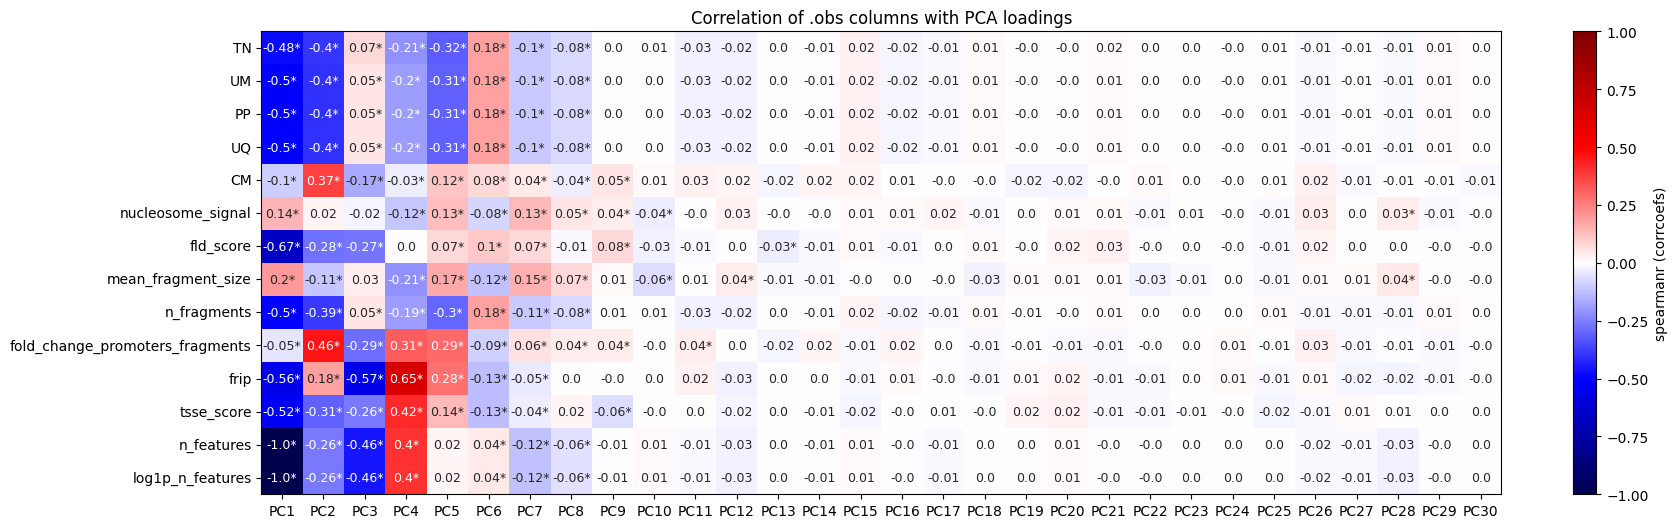

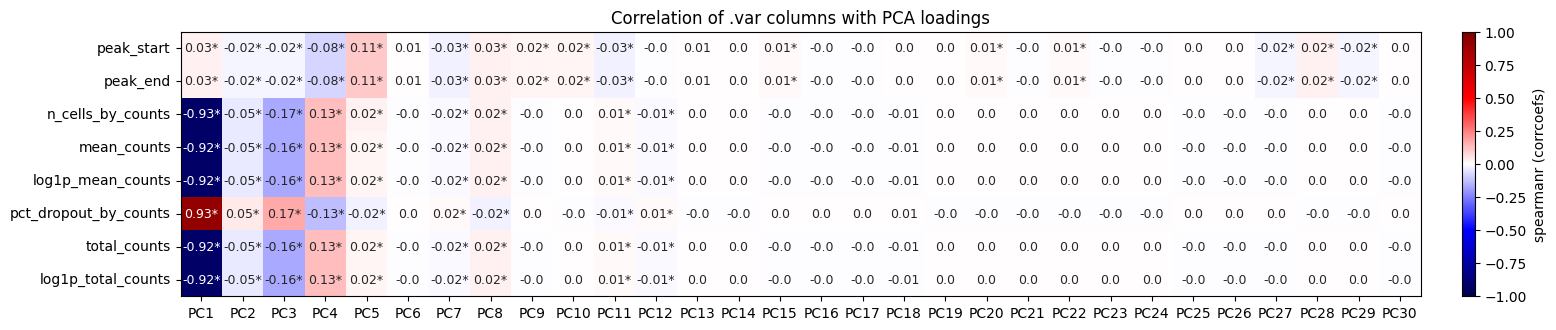

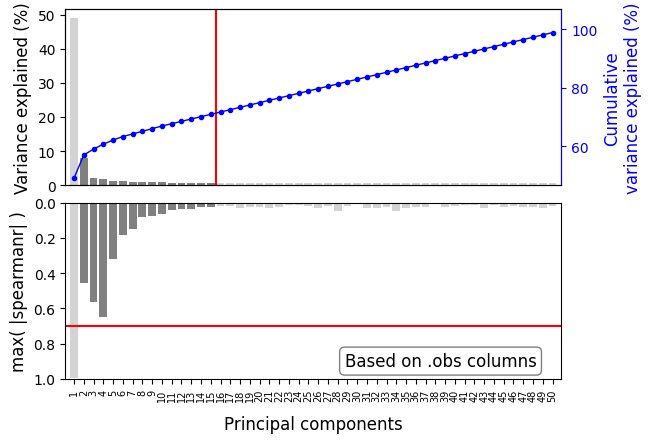

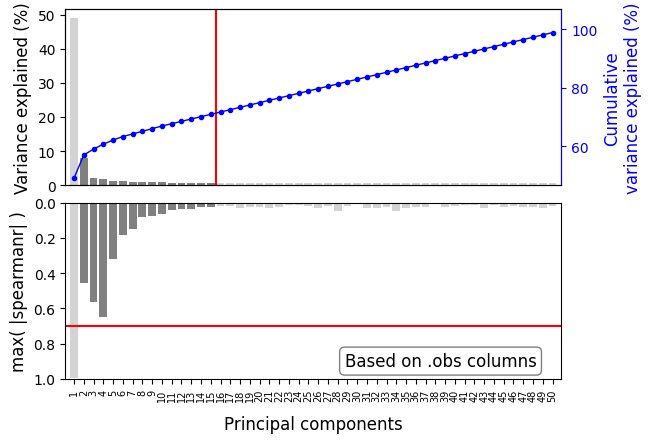

Computing chunks:  80%|███████▉  | 107/134 [00:33<00:08,  3.16it/s]Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Computing chunks:  82%|████████▏ | 110/134 [00:34<00:08,  2.99it/s]Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Computing chunks:  85%|████████▌ | 114/134 [00:35<00:06,  3.29it/s]N

Embedding quality by the distance score: 1.4838319246750746


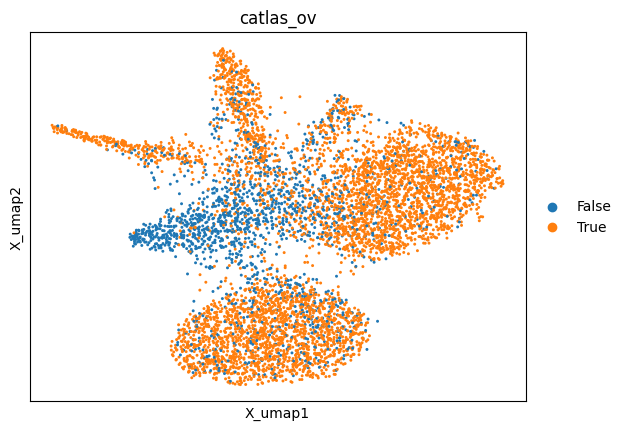

-----------------------
metric: fld_score
min: 500
max: --
-----------------------


AnnData object with n_obs × n_vars = 2088 × 101651
    obs: 'TN', 'UM', 'PP', 'UQ', 'CM', 'file', 'sample', 'nucleosome_signal', 'fld_score', 'mean_fragment_size', 'n_fragments', 'fold_change_promoters_fragments', 'frip', 'tsse_score', 'catlas_ov', 'cell type', 'n_features', 'log1p_n_features'
    var: 'peak_chr', 'peak_start', 'peak_end', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts'
    uns: 'files', 'sctoolbox'

TN      UM      PP      UQ      CM  \
barcode                                                           
AAACTACCAGAAATAAGGCCAG   7244.0  6422.0  6403.0  6403.0   113.0   
AAACTACCAGAACCGAATTCTC   4864.0  4390.0  4381.0  4381.0   168.0   
AAACTACCAGAAGTTGTGCTAC   5590.0  5073.0  5060.0  5059.0   110.0   
AAACTACCAGAATGGAGCAACA   3836.0  3289.0  3274.0  3272.0   817.0   
AAACTACCAGACCTCACTCGAA   8187.0  7076.0  7054.0  7054.0   564.0   
...                         ...     ...     ...     ...     ...   
TTCCATCCTCCACAAATCAACC   3749.0  3189.0  3180.0  3179.0  1160.0   
TTCCATCCTCGGATAAAGGGAT   3878.0  3329.0  3314.0  3313.0   828.0   
TTCCATCCTCGGATACTCGTGA  10107.0  8575.0  8562.0  8562.0   352.0   
TTCCATCCTCTGCGTCGAGTAC   4424.0  3782.0  3770.0  3770.0   310.0   
TTCCATCCTCTGGTGAGGTGAT   8161.0  6995.0  6977.0  6977.0   127.0   

                                                                     file  \
barcode                                                                     
AAACTACCAGAAATAAGGCCAG  /mnt/workspace2/jdetlef/peakqc_paperprep/bench...   
AAACTACCAGAACCGAATTCTC  /mnt/workspace2/jdetlef/peakqc_paperprep/bench...   
AAACTACCAGAAGTTGTGCTAC  /mnt/workspace2/jdetlef/peakqc_paperprep/bench...   
AAACTACCAGAATGGAGCAACA  /mnt/workspace2/jdetlef/peakqc_paperprep/bench...   
AAACTACCAGACCTCACTCGAA  /mnt/workspace2/jdetlef/peakqc_paperprep/bench...   
...                                                                   ...   
TTCCATCCTCCACAAATCAACC  /mnt/workspace2/jdetlef/peakqc_paperprep/bench...   
TTCCATCCTCGGATAAAGGGAT  /mnt/workspace2/jdetlef/peakqc_paperprep/bench...   
TTCCATCCTCGGATACTCGTGA  /mnt/workspace2/jdetlef/peakqc_paperprep/bench...   
TTCCATCCTCTGCGTCGAGTAC  /mnt/workspace2/jdetlef/peakqc_paperprep/bench...   
TTCCATCCTCTGGTGAGGTGAT  /mnt/workspace2/jdetlef/peakqc_paperprep/bench...   

                       sample  nucleosome_signal    fld_score  \
barcode                                                         
AAACTACCAGAAATAAGGCCAG     MB           0.526786  1110.717402   
AAACTACCAGAACCGAATTCTC     MB           0.339806   567.822923   
AAACTACCAGAAGTTGTGCTAC     MB           0.460000   577.771706   
AAACTACCAGAATGGAGCAACA     MB           0.333333   520.455216   
AAACTACCAGACCTCACTCGAA     MB           0.477612   629.632559   
...                       ...                ...          ...   
TTCCATCCTCCACAAATCAACC     MB           0.700000   563.230877   
TTCCATCCTCGGATAAAGGGAT     MB           0.638889   601.036511   
TTCCATCCTCGGATACTCGTGA     MB           0.422727   640.555136   
TTCCATCCTCTGCGTCGAGTAC     MB           0.860000   772.765143   
TTCCATCCTCTGGTGAGGTGAT     MB           0.437086   760.310800   

                        mean_fragment_size  n_fragments  \
barcode                                                   
AAACTACCAGAAATAAGGCCAG              139.16       6615.0   
AAACTACCAGAACCGAATTCTC              123.41       4205.0   
AAACTACCAGAAGTTGTGCTAC              130.90       4724.0   
AAACTACCAGAATGGAGCAACA              146.46       3823.0   
AAACTACCAGACCTCACTCGAA              140.74       6552.0   
...                                    ...          ...   
TTCCATCCTCCACAAATCAACC              144.98       4537.0   
TTCCATCCTCGGATAAAGGGAT              144.85       3193.0   
TTCCATCCTCGGATACTCGTGA              131.34       8125.0   
TTCCATCCTCTGCGTCGAGTAC              153.43       3363.0   
TTCCATCCTCTGGTGAGGTGAT              121.68       6477.0   

                        fold_change_promoters_fragments      frip  tsse_score  \
barcode                                                                         
AAACTACCAGAAATAAGGCCAG                         0.355502  0.414752    3.795517   
AAACTACCAGAACCGAATTCTC                         0.336504  0.373841    4.055779   
AAACTACCAGAAGTTGTGCTAC                         0.222269  0.341660    5.641159   
AAACTACCAGAATGGAGCAACA                         1.899555  0.243264    0.433382   
AAACTACCAGACCTCACTCGAA                         0.313187

peak_chr  peak_start  peak_end  n_cells_by_counts  \
name                                                                       
chr1:10007-10565           chr1       10007     10565                 59   
chr1:28992-29433           chr1       28992     29433                 13   
chr1:136833-136999         chr1      136833    136999                  1   
chr1:180705-181054         chr1      180705    181054                 54   
chr1:181132-181985         chr1      181132    181985                 71   
...                         ...         ...       ...                ...   
chrY:56850348-56850516     chrY    56850348  56850516                114   
chrY:56850724-56850993     chrY    56850724  56850993                274   
chrY:56851055-56851204     chrY    56851055  56851204                 94   
chrY:56870833-56870955     chrY    56870833  56870955                 55   
chrY:56886632-56886906     chrY    56886632  56886906                 15   

                        mean_counts  log1p_mean_counts  pct_dropout_by_counts  \
name                                                                            
chr1:10007-10565           0.000849           0.000849              99.915072   
chr1:28992-29433           0.000187           0.000187              99.981287   
chr1:136833-136999         0.000014           0.000014              99.998561   
chr1:180705-181054         0.000806           0.000806              99.922270   
chr1:181132-181985         0.001022           0.001021              99.897799   
...                             ...                ...                    ...   
chrY:56850348-56850516     0.001684           0.001683              99.835903   
chrY:56850724-56850993     0.004045           0.004037              99.605591   
chrY:56851055-56851204     0.001367           0.001367              99.864692   
chrY:56870833-56870955     0.000835           0.000835              99.920830   
chrY:56886632-56886906     0.000216           0.000216              99.978408   

                        total_counts  log1p_total_counts  
name                                                      
chr1:10007-10565                59.0            4.094345  
chr1:28992-29433                13.0            2.639057  
chr1:136833-136999               1.0            0.693147  
chr1:180705-181054              56.0            4.043051  
chr1:181132-181985              71.0            4.276666  
...                              ...                 ...  
chrY:56850348-56850516         117.0            4.770685  
chrY:56850724-56850993         281.0            5.641907  
chrY:56851055-56851204          95.0            4.564348  
chrY:56870833-56870955          58.0            4.077538  
chrY:56886632-56886906          15.0            2.772589  

[101651 rows x 9 columns]

Removing chromosomal features...
Removing gender related features...


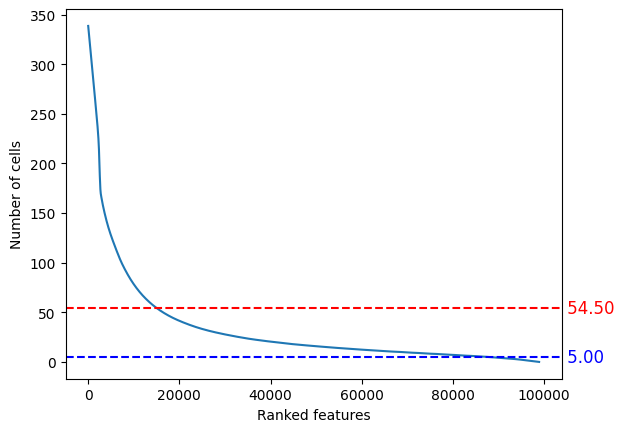

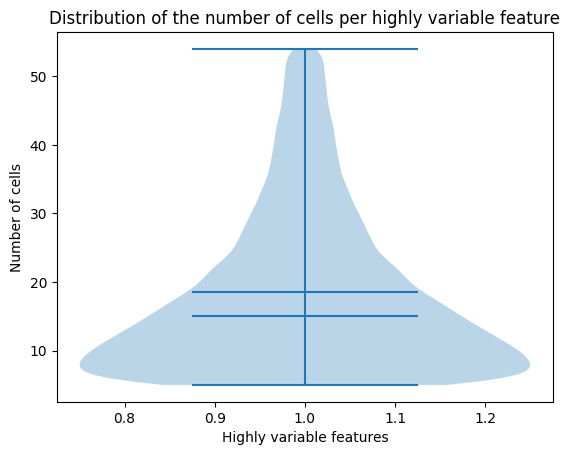

[INFO] Performing TFIDF and LSI...


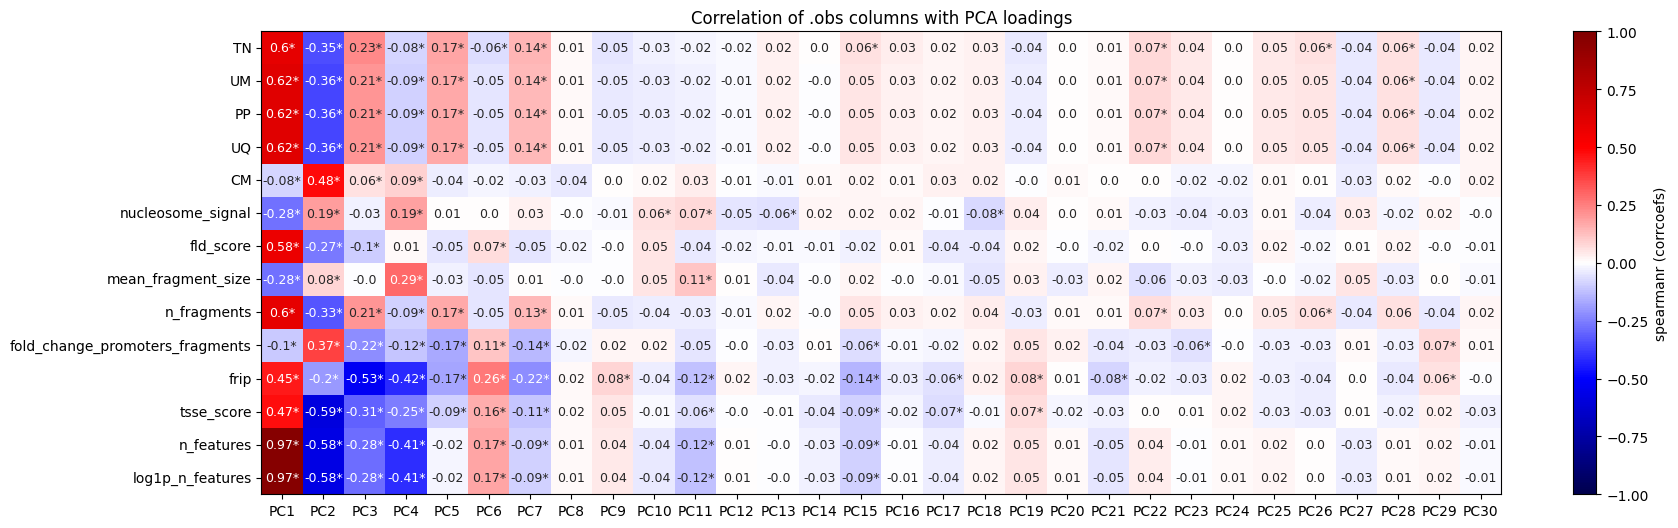

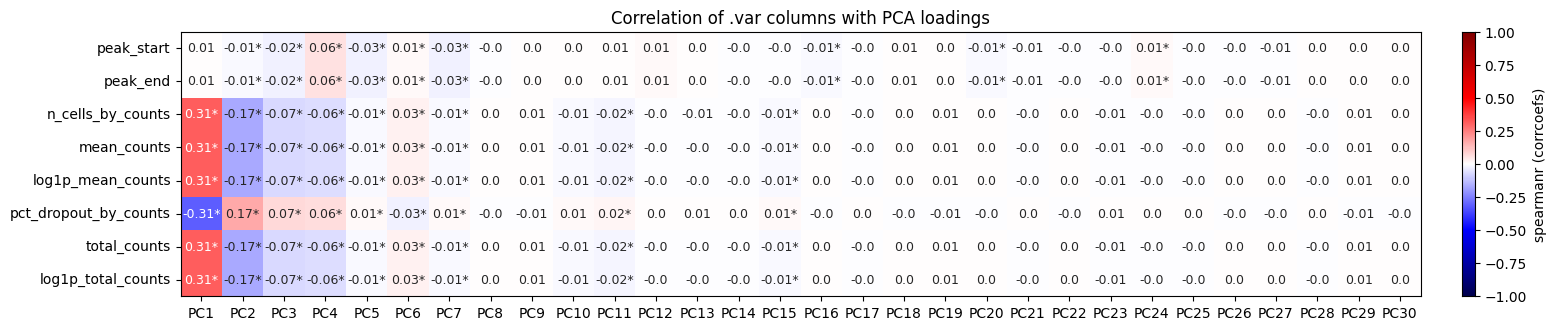

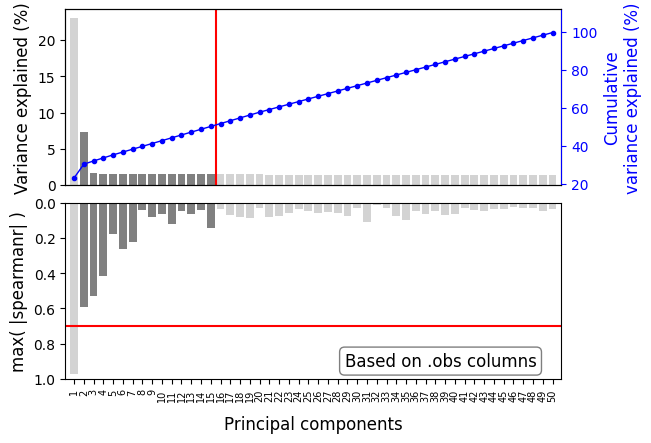

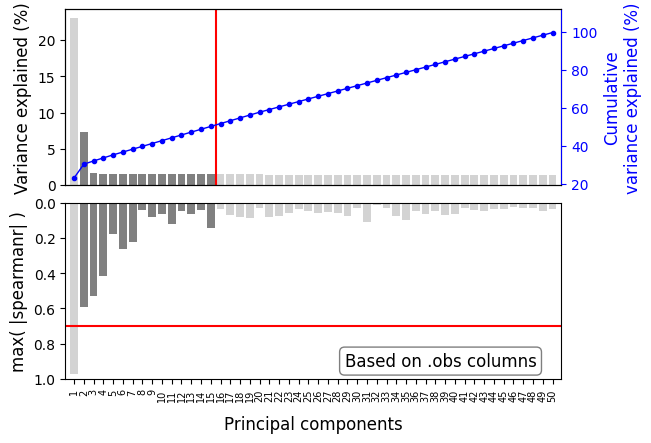

Computing chunks: 100%|██████████| 42/42 [00:13<00:00,  3.18it/s]

Embedding quality by the distance score: 1.487477573051075


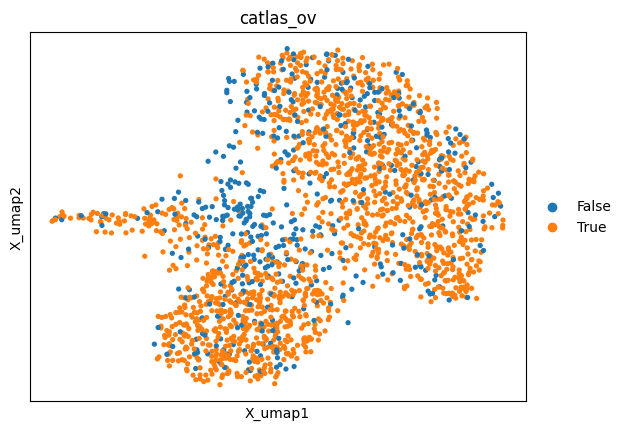

-----------------------
metric: nucleosome_signal
min: 0
max: 0.1
-----------------------


AnnData object with n_obs × n_vars = 10007 × 101651
    obs: 'TN', 'UM', 'PP', 'UQ', 'CM', 'file', 'sample', 'nucleosome_signal', 'fld_score', 'mean_fragment_size', 'n_fragments', 'fold_change_promoters_fragments', 'frip', 'tsse_score', 'catlas_ov', 'cell type', 'n_features', 'log1p_n_features'
    var: 'peak_chr', 'peak_start', 'peak_end', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts'
    uns: 'files', 'sctoolbox'

TN    UM    PP    UQ    CM  \
barcode                                                
AAACTACCAGAAAGCACTAGCG  25.0  18.0  18.0  18.0  10.0   
AAACTACCAGAAAGCGGGAGCT  26.0  21.0  21.0  21.0   2.0   
AAACTACCAGAAAGGAACAGAC  41.0  35.0  35.0  35.0   3.0   
AAACTACCAGAAAGGATCGGCT  25.0  18.0  18.0  18.0   1.0   
AAACTACCAGAAAGGGATGCCA  28.0  21.0  21.0  21.0   1.0   
...                      ...   ...   ...   ...   ...   
TTCCATCCTCTTAGGGACCCTC  11.0   9.0   9.0   9.0   2.0   
TTCCATCCTCTTCACTACGTAG  10.0   7.0   7.0   7.0   0.0   
TTCCATCCTCTTGACAAGTCCT   5.0   5.0   5.0   5.0   0.0   
TTCCATCCTCTTGCATGTACGC   6.0   5.0   5.0   5.0   0.0   
TTCCATCCTCTTGTCATGCGTG   6.0   4.0   4.0   4.0   0.0   

                                                                     file  \
barcode                                                                     
AAACTACCAGAAAGCACTAGCG  /mnt/workspace2/jdetlef/peakqc_paperprep/bench...   
AAACTACCAGAAAGCGGGAGCT  /mnt/workspace2/jdetlef/peakqc_paperprep/bench...   
AAACTACCAGAAAGGAACAGAC  /mnt/workspace2/jdetlef/peakqc_paperprep/bench...   
AAACTACCAGAAAGGATCGGCT  /mnt/workspace2/jdetlef/peakqc_paperprep/bench...   
AAACTACCAGAAAGGGATGCCA  /mnt/workspace2/jdetlef/peakqc_paperprep/bench...   
...                                                                   ...   
TTCCATCCTCTTAGGGACCCTC  /mnt/workspace2/jdetlef/peakqc_paperprep/bench...   
TTCCATCCTCTTCACTACGTAG  /mnt/workspace2/jdetlef/peakqc_paperprep/bench...   
TTCCATCCTCTTGACAAGTCCT  /mnt/workspace2/jdetlef/peakqc_paperprep/bench...   
TTCCATCCTCTTGCATGTACGC  /mnt/workspace2/jdetlef/peakqc_paperprep/bench...   
TTCCATCCTCTTGTCATGCGTG  /mnt/workspace2/jdetlef/peakqc_paperprep/bench...   

                       sample  nucleosome_signal  fld_score  \
barcode                                                       
AAACTACCAGAAAGCACTAGCG     MB                0.0   1.747029   
AAACTACCAGAAAGCGGGAGCT     MB                0.0   2.226004   
AAACTACCAGAAAGGAACAGAC     MB                0.0   4.359279   
AAACTACCAGAAAGGATCGGCT     MB                0.0   5.338967   
AAACTACCAGAAAGGGATGCCA     MB                0.0   2.849455   
...                       ...                ...        ...   
TTCCATCCTCTTAGGGACCCTC     MB                0.0   1.631997   
TTCCATCCTCTTCACTACGTAG     MB                0.0   0.729911   
TTCCATCCTCTTGACAAGTCCT     MB                0.0   0.483395   
TTCCATCCTCTTGCATGTACGC     MB                0.0   0.693256   
TTCCATCCTCTTGTCATGCGTG     MB                0.0   0.204747   

                        mean_fragment_size  n_fragments  \
barcode                                                   
AAACTACCAGAAAGCACTAGCG               60.29          7.0   
AAACTACCAGAAAGCGGGAGCT              166.88          8.0   
AAACTACCAGAAAGGAACAGAC              106.09         23.0   
AAACTACCAGAAAGGATCGGCT              117.07         14.0   
AAACTACCAGAAAGGGATGCCA              109.25         20.0   
...                                    ...          ...   
TTCCATCCTCTTAGGGACCCTC               71.33         12.0   
TTCCATCCTCTTCACTACGTAG               90.22          9.0   
TTCCATCCTCTTGACAAGTCCT               53.29          7.0   
TTCCATCCTCTTGCATGTACGC               28.33          3.0   
TTCCATCCTCTTGTCATGCGTG              111.17          6.0   

                        fold_change_promoters_fragments      frip  tsse_score  \
barcode                                                                         
AAACTACCAGAAAGCACTAGCG                         0.714286       NaN        0.00   
AAACTACCAGAAAGCGGGAGCT                         0.000000  0.125000         NaN   
AAACTACCAGAAAGGAACAGAC                         0.391304  0.304348        0.82   
AAACTACCAGAAAGGATCGGCT                         0.000000  0.071429        0.48   
AAACTACCAGAAAGGGATGCCA                         0.100000  0.300000        0.98   
...                                                 ...       ...         ...   
TTCCATCCTCTTAGGGACCCTC                         0.250000  0.

peak_chr  peak_start  peak_end  n_cells_by_counts  \
name                                                                       
chr1:10007-10565           chr1       10007     10565                 59   
chr1:28992-29433           chr1       28992     29433                 13   
chr1:136833-136999         chr1      136833    136999                  1   
chr1:180705-181054         chr1      180705    181054                 54   
chr1:181132-181985         chr1      181132    181985                 71   
...                         ...         ...       ...                ...   
chrY:56850348-56850516     chrY    56850348  56850516                114   
chrY:56850724-56850993     chrY    56850724  56850993                274   
chrY:56851055-56851204     chrY    56851055  56851204                 94   
chrY:56870833-56870955     chrY    56870833  56870955                 55   
chrY:56886632-56886906     chrY    56886632  56886906                 15   

                        mean_counts  log1p_mean_counts  pct_dropout_by_counts  \
name                                                                            
chr1:10007-10565           0.000849           0.000849              99.915072   
chr1:28992-29433           0.000187           0.000187              99.981287   
chr1:136833-136999         0.000014           0.000014              99.998561   
chr1:180705-181054         0.000806           0.000806              99.922270   
chr1:181132-181985         0.001022           0.001021              99.897799   
...                             ...                ...                    ...   
chrY:56850348-56850516     0.001684           0.001683              99.835903   
chrY:56850724-56850993     0.004045           0.004037              99.605591   
chrY:56851055-56851204     0.001367           0.001367              99.864692   
chrY:56870833-56870955     0.000835           0.000835              99.920830   
chrY:56886632-56886906     0.000216           0.000216              99.978408   

                        total_counts  log1p_total_counts  
name                                                      
chr1:10007-10565                59.0            4.094345  
chr1:28992-29433                13.0            2.639057  
chr1:136833-136999               1.0            0.693147  
chr1:180705-181054              56.0            4.043051  
chr1:181132-181985              71.0            4.276666  
...                              ...                 ...  
chrY:56850348-56850516         117.0            4.770685  
chrY:56850724-56850993         281.0            5.641907  
chrY:56851055-56851204          95.0            4.564348  
chrY:56870833-56870955          58.0            4.077538  
chrY:56886632-56886906          15.0            2.772589  

[101651 rows x 9 columns]

Removing chromosomal features...
Removing gender related features...


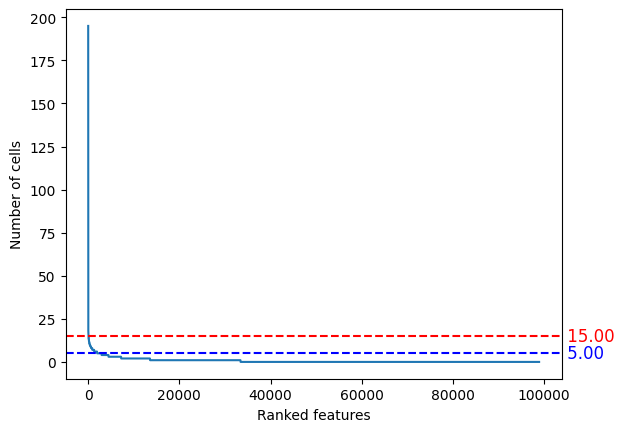

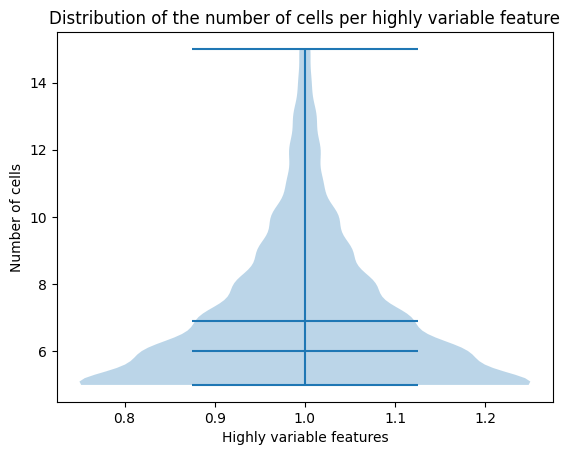

[INFO] Performing TFIDF and LSI...


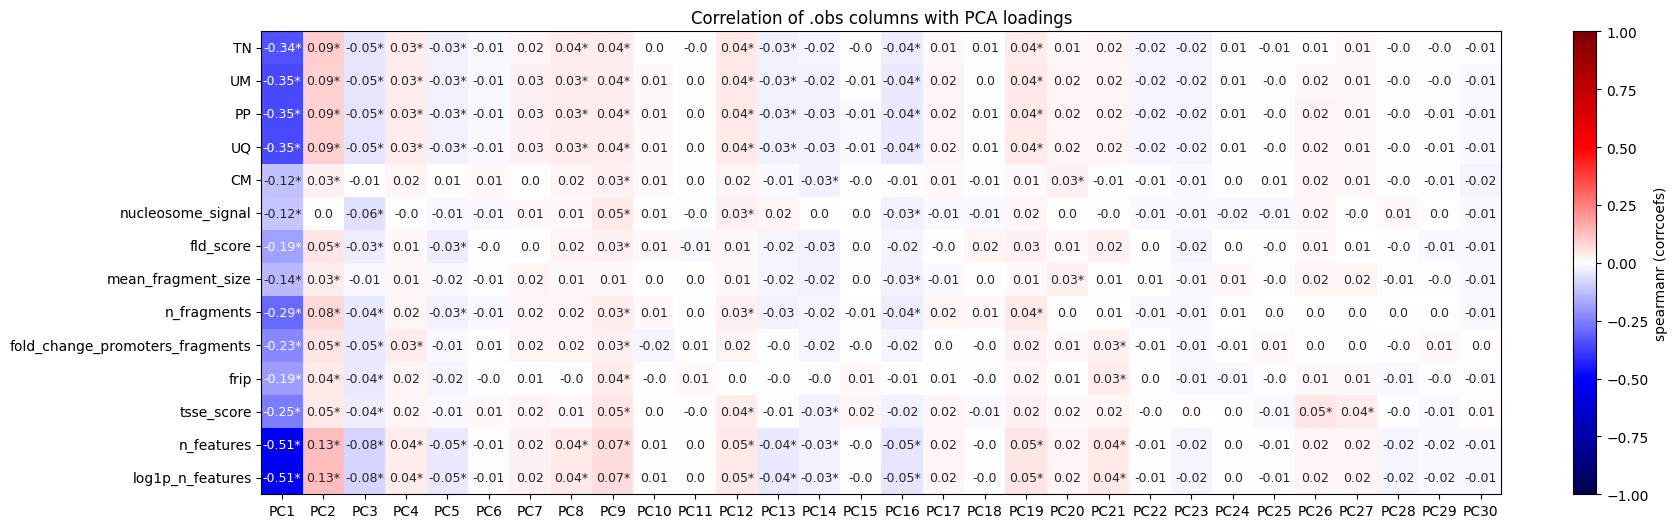

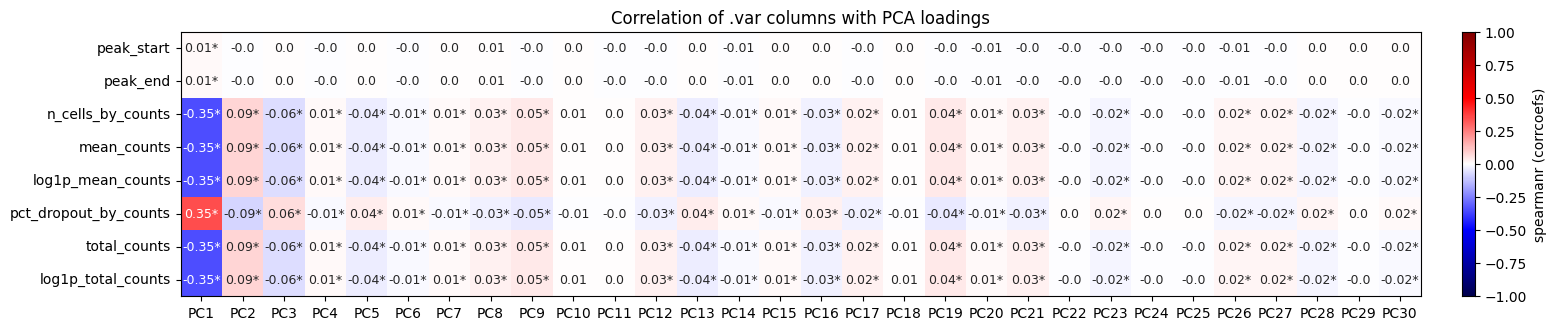

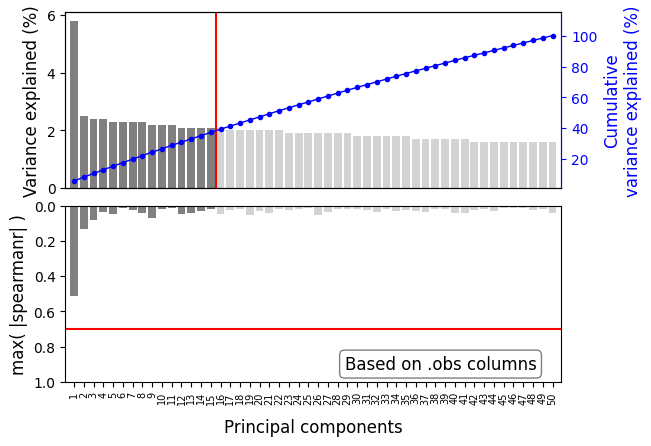

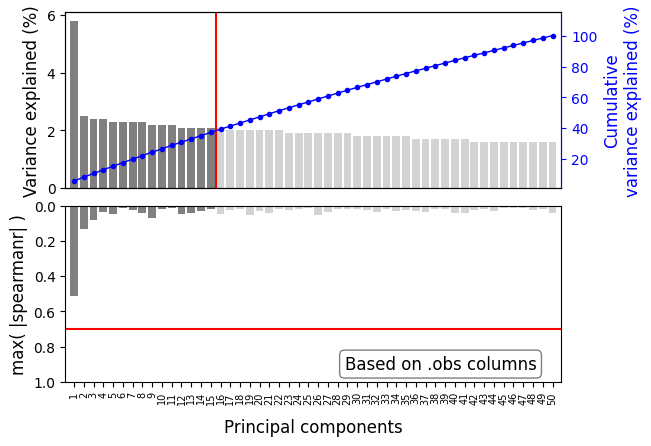

Computing chunks:  52%|█████▏    | 104/201 [00:20<00:21,  4.56it/s]Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Computing chunks:  54%|█████▎    | 108/201 [00:21<00:21,  4.30it/s]Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may

Embedding quality by the distance score: 1.5


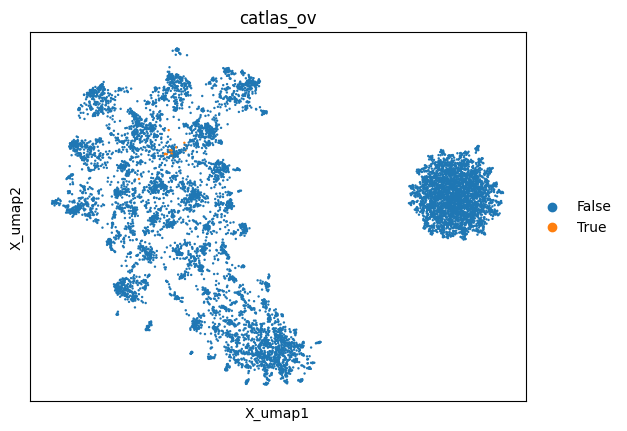

-----------------------
metric: nucleosome_signal
min: 0.1
max: 0.7
-----------------------


AnnData object with n_obs × n_vars = 10073 × 101651
    obs: 'TN', 'UM', 'PP', 'UQ', 'CM', 'file', 'sample', 'nucleosome_signal', 'fld_score', 'mean_fragment_size', 'n_fragments', 'fold_change_promoters_fragments', 'frip', 'tsse_score', 'catlas_ov', 'cell type', 'n_features', 'log1p_n_features'
    var: 'peak_chr', 'peak_start', 'peak_end', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts'
    uns: 'files', 'sctoolbox'

TN      UM      PP      UQ     CM  \
barcode                                                         
AAACTACCAGAAACCTAAGTGG  7116.0  6025.0  6011.0  6011.0  218.0   
AAACTACCAGAAACGGATCAGT  3692.0  3009.0  3004.0  3004.0   69.0   
AAACTACCAGAAAGCCCACGAC    22.0    17.0    17.0    17.0    0.0   
AAACTACCAGAAATAAGGCCAG  7244.0  6422.0  6403.0  6403.0  113.0   
AAACTACCAGAACATGAAGCGC  1895.0  1654.0  1649.0  1649.0   71.0   
...                        ...     ...     ...     ...    ...   
TTCCATCCTCTTAGTGCTAGCA  4475.0  3875.0  3866.0  3867.0  292.0   
TTCCATCCTCTTGAGTGCTGTG  1122.0   993.0   990.0   990.0   35.0   
TTCCATCCTCTTGATGCGACCA   697.0   625.0   624.0   624.0   18.0   
TTCCATCCTCTTTCTGCAGACT   584.0   506.0   506.0   506.0   27.0   
TTCCATCCTCTTTGTGTTACCG   629.0   518.0   517.0   517.0   39.0   

                                                                     file  \
barcode                                                                     
AAACTACCAGAAACCTAAGTGG  /mnt/workspace2/jdetlef/peakqc_paperprep/bench...   
AAACTACCAGAAACGGATCAGT  /mnt/workspace2/jdetlef/peakqc_paperprep/bench...   
AAACTACCAGAAAGCCCACGAC  /mnt/workspace2/jdetlef/peakqc_paperprep/bench...   
AAACTACCAGAAATAAGGCCAG  /mnt/workspace2/jdetlef/peakqc_paperprep/bench...   
AAACTACCAGAACATGAAGCGC  /mnt/workspace2/jdetlef/peakqc_paperprep/bench...   
...                                                                   ...   
TTCCATCCTCTTAGTGCTAGCA  /mnt/workspace2/jdetlef/peakqc_paperprep/bench...   
TTCCATCCTCTTGAGTGCTGTG  /mnt/workspace2/jdetlef/peakqc_paperprep/bench...   
TTCCATCCTCTTGATGCGACCA  /mnt/workspace2/jdetlef/peakqc_paperprep/bench...   
TTCCATCCTCTTTCTGCAGACT  /mnt/workspace2/jdetlef/peakqc_paperprep/bench...   
TTCCATCCTCTTTGTGTTACCG  /mnt/workspace2/jdetlef/peakqc_paperprep/bench...   

                       sample  nucleosome_signal    fld_score  \
barcode                                                         
AAACTACCAGAAACCTAAGTGG     MB           0.434524   305.939935   
AAACTACCAGAAACGGATCAGT     MB           0.462500   184.560884   
AAACTACCAGAAAGCCCACGAC     MB           0.500000     5.754991   
AAACTACCAGAAATAAGGCCAG     MB           0.526786  1110.717402   
AAACTACCAGAACATGAAGCGC     MB           0.653846   171.855951   
...                       ...                ...          ...   
TTCCATCCTCTTAGTGCTAGCA     MB           0.481013   391.046807   
TTCCATCCTCTTGAGTGCTGTG     MB           0.200000   128.721497   
TTCCATCCTCTTGATGCGACCA     MB           0.700000    85.308002   
TTCCATCCTCTTTCTGCAGACT     MB           0.421053    58.356201   
TTCCATCCTCTTTGTGTTACCG     MB           0.294118    40.761008   

                        mean_fragment_size  n_fragments  \
barcode                                                   
AAACTACCAGAAACCTAAGTGG              132.91       5861.0   
AAACTACCAGAAACGGATCAGT              137.64       2933.0   
AAACTACCAGAAAGCCCACGAC              149.96         17.0   
AAACTACCAGAAATAAGGCCAG              139.16       6615.0   
AAACTACCAGAACATGAAGCGC              145.87       1592.0   
...                                    ...          ...   
TTCCATCCTCTTAGTGCTAGCA              132.70       3816.0   
TTCCATCCTCTTGAGTGCTGTG              129.88        987.0   
TTCCATCCTCTTGATGCGACCA              137.06        643.0   
TTCCATCCTCTTTCTGCAGACT              129.30        520.0   
TTCCATCCTCTTTGTGTTACCG              137.91        487.0   

                        fold_change_promoters_fragments      frip  tsse_score  \
barcode                                                                         
AAACTACCAGAAACCTAAGTGG                         0.163795  0.112779    1.513383   
AAACTACCAGAAACGGATCAGT                         0.171838  0.086260    1.208600   
AAACTACCAGAAAGCCCACGAC                         0.352941  0.647059    2.800000   
AAACTACCAGAAATAAGGCCAG                         0.355502  0.414752    3.795517   
AAACTACCAGAACATGAAGCGC                         0.291457  0.194095    1.574153   

peak_chr  peak_start  peak_end  n_cells_by_counts  \
name                                                                       
chr1:10007-10565           chr1       10007     10565                 59   
chr1:28992-29433           chr1       28992     29433                 13   
chr1:136833-136999         chr1      136833    136999                  1   
chr1:180705-181054         chr1      180705    181054                 54   
chr1:181132-181985         chr1      181132    181985                 71   
...                         ...         ...       ...                ...   
chrY:56850348-56850516     chrY    56850348  56850516                114   
chrY:56850724-56850993     chrY    56850724  56850993                274   
chrY:56851055-56851204     chrY    56851055  56851204                 94   
chrY:56870833-56870955     chrY    56870833  56870955                 55   
chrY:56886632-56886906     chrY    56886632  56886906                 15   

                        mean_counts  log1p_mean_counts  pct_dropout_by_counts  \
name                                                                            
chr1:10007-10565           0.000849           0.000849              99.915072   
chr1:28992-29433           0.000187           0.000187              99.981287   
chr1:136833-136999         0.000014           0.000014              99.998561   
chr1:180705-181054         0.000806           0.000806              99.922270   
chr1:181132-181985         0.001022           0.001021              99.897799   
...                             ...                ...                    ...   
chrY:56850348-56850516     0.001684           0.001683              99.835903   
chrY:56850724-56850993     0.004045           0.004037              99.605591   
chrY:56851055-56851204     0.001367           0.001367              99.864692   
chrY:56870833-56870955     0.000835           0.000835              99.920830   
chrY:56886632-56886906     0.000216           0.000216              99.978408   

                        total_counts  log1p_total_counts  
name                                                      
chr1:10007-10565                59.0            4.094345  
chr1:28992-29433                13.0            2.639057  
chr1:136833-136999               1.0            0.693147  
chr1:180705-181054              56.0            4.043051  
chr1:181132-181985              71.0            4.276666  
...                              ...                 ...  
chrY:56850348-56850516         117.0            4.770685  
chrY:56850724-56850993         281.0            5.641907  
chrY:56851055-56851204          95.0            4.564348  
chrY:56870833-56870955          58.0            4.077538  
chrY:56886632-56886906          15.0            2.772589  

[101651 rows x 9 columns]

Removing chromosomal features...
Removing gender related features...


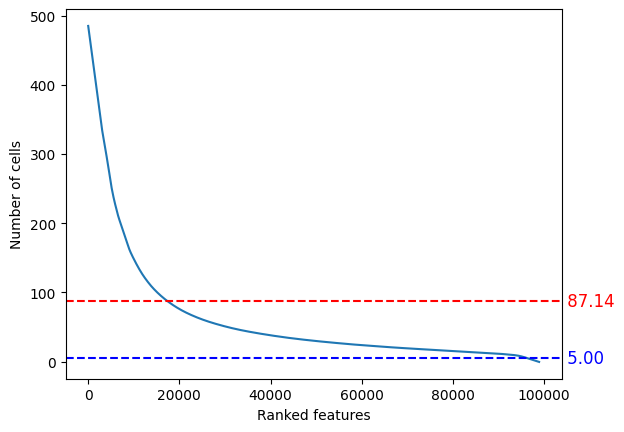

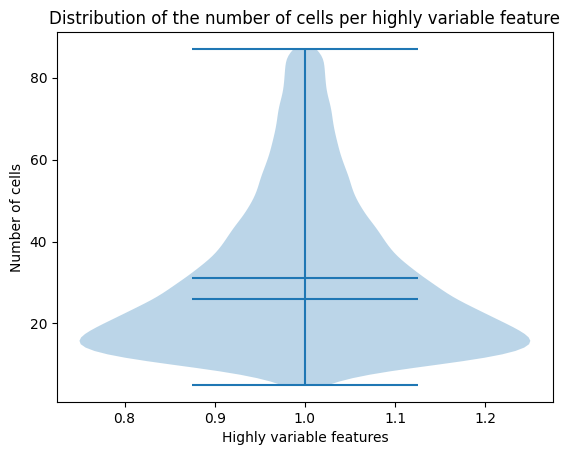

[INFO] Performing TFIDF and LSI...


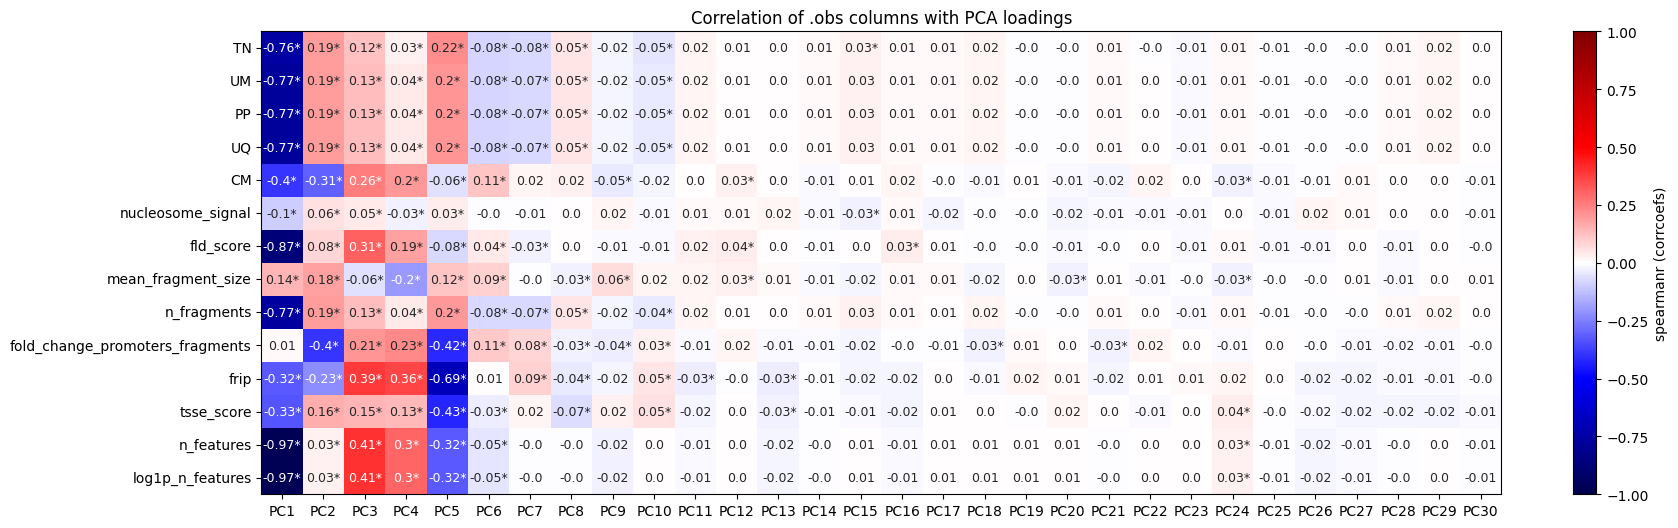

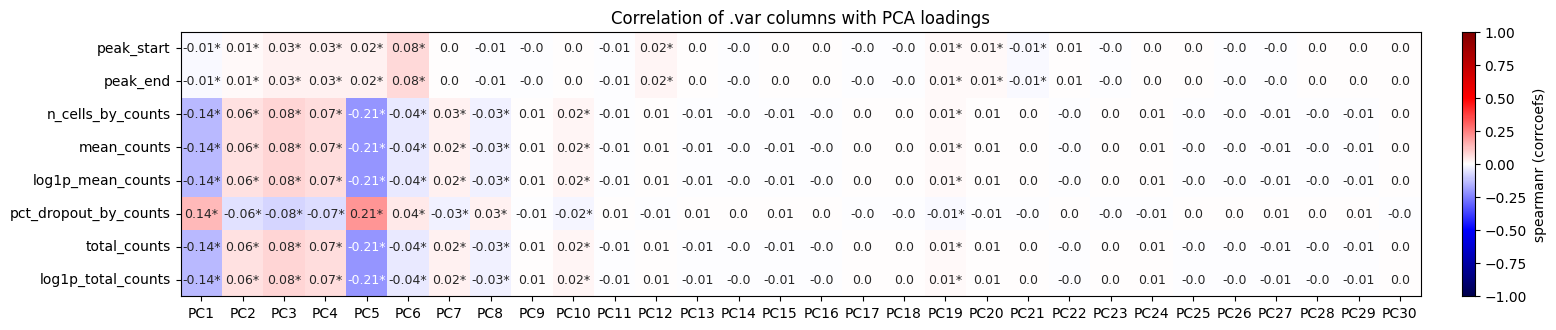

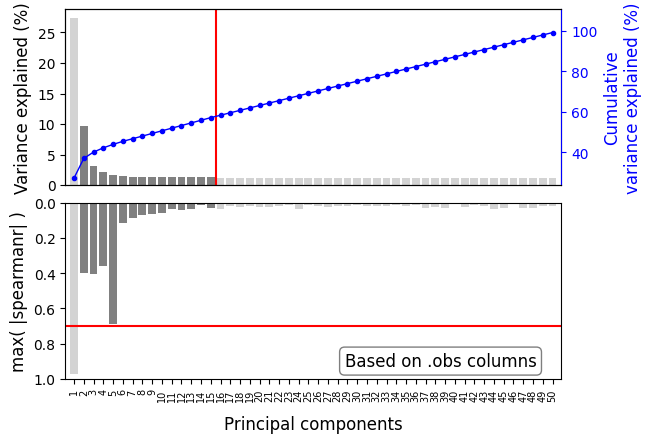

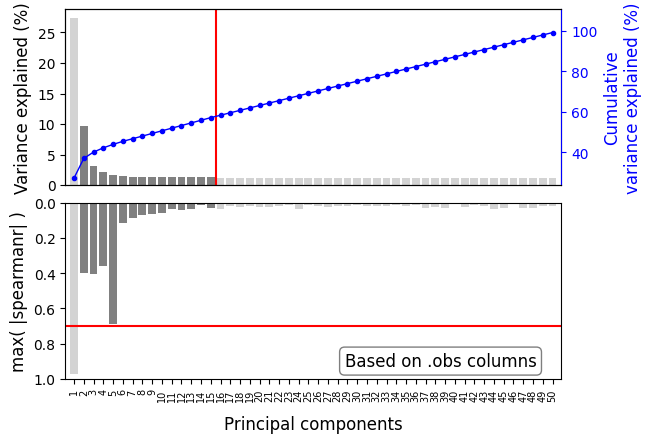

Computing chunks:  52%|█████▏    | 106/202 [00:33<00:36,  2.64it/s]Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Computing chunks:  54%|█████▍    | 109/202 [00:34<00:34,  2.68it/s]Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Computing chunks:  56%|█████▋    | 114/202 [00:36<00:26,  3.28it/s]N

Embedding quality by the distance score: 1.4962742896991923


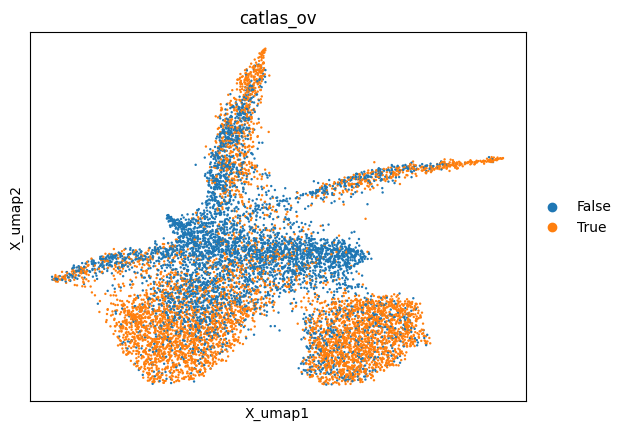

-----------------------
metric: nucleosome_signal
min: 0.7
max: 2
-----------------------


AnnData object with n_obs × n_vars = 49226 × 101651
    obs: 'TN', 'UM', 'PP', 'UQ', 'CM', 'file', 'sample', 'nucleosome_signal', 'fld_score', 'mean_fragment_size', 'n_fragments', 'fold_change_promoters_fragments', 'frip', 'tsse_score', 'catlas_ov', 'cell type', 'n_features', 'log1p_n_features'
    var: 'peak_chr', 'peak_start', 'peak_end', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts'
    uns: 'files', 'sctoolbox'

TN     UM     PP     UQ     CM  \
barcode                                                     
AAACTACCAGAAACCCGAGATA   28.0   21.0   21.0   21.0    1.0   
AAACTACCAGAAACGTCCCGTT   21.0   19.0   19.0   19.0    0.0   
AAACTACCAGAAACTAGCCCTA   22.0   19.0   19.0   19.0    2.0   
AAACTACCAGAAATGCTACGGG   22.0   17.0   17.0   17.0    1.0   
AAACTACCAGAAATTGAGGAGG   25.0   18.0   18.0   18.0    2.0   
...                       ...    ...    ...    ...    ...   
TTCCATCCTCTTTAACGCCTCT    8.0    8.0    8.0    8.0    0.0   
TTCCATCCTCTTTCCACGCAGT    8.0    8.0    8.0    8.0    1.0   
TTCCATCCTCTTTCGAAGAAGG  721.0  600.0  598.0  598.0  153.0   
TTCCATCCTCTTTCGCGTGTAA    4.0    4.0    4.0    4.0    0.0   
TTCCATCCTCTTTGCCGGAAGG    5.0    5.0    5.0    5.0    0.0   

                                                                     file  \
barcode                                                                     
AAACTACCAGAAACCCGAGATA  /mnt/workspace2/jdetlef/peakqc_paperprep/bench...   
AAACTACCAGAAACGTCCCGTT  /mnt/workspace2/jdetlef/peakqc_paperprep/bench...   
AAACTACCAGAAACTAGCCCTA  /mnt/workspace2/jdetlef/peakqc_paperprep/bench...   
AAACTACCAGAAATGCTACGGG  /mnt/workspace2/jdetlef/peakqc_paperprep/bench...   
AAACTACCAGAAATTGAGGAGG  /mnt/workspace2/jdetlef/peakqc_paperprep/bench...   
...                                                                   ...   
TTCCATCCTCTTTAACGCCTCT  /mnt/workspace2/jdetlef/peakqc_paperprep/bench...   
TTCCATCCTCTTTCCACGCAGT  /mnt/workspace2/jdetlef/peakqc_paperprep/bench...   
TTCCATCCTCTTTCGAAGAAGG  /mnt/workspace2/jdetlef/peakqc_paperprep/bench...   
TTCCATCCTCTTTCGCGTGTAA  /mnt/workspace2/jdetlef/peakqc_paperprep/bench...   
TTCCATCCTCTTTGCCGGAAGG  /mnt/workspace2/jdetlef/peakqc_paperprep/bench...   

                       sample  nucleosome_signal  fld_score  \
barcode                                                       
AAACTACCAGAAACCCGAGATA     MB                1.0   0.003301   
AAACTACCAGAAACGTCCCGTT     MB                1.0   3.400717   
AAACTACCAGAAACTAGCCCTA     MB                1.0  10.770080   
AAACTACCAGAAATGCTACGGG     MB                1.0   0.836900   
AAACTACCAGAAATTGAGGAGG     MB                1.0   0.488350   
...                       ...                ...        ...   
TTCCATCCTCTTTAACGCCTCT     MB                1.0   0.576100   
TTCCATCCTCTTTCCACGCAGT     MB                1.0   0.596493   
TTCCATCCTCTTTCGAAGAAGG     MB                1.0  76.517145   
TTCCATCCTCTTTCGCGTGTAA     MB                1.0   0.128179   
TTCCATCCTCTTTGCCGGAAGG     MB                1.0   0.053747   

                        mean_fragment_size  n_fragments  \
barcode                                                   
AAACTACCAGAAACCCGAGATA              117.23         13.0   
AAACTACCAGAAACGTCCCGTT               79.43         20.0   
AAACTACCAGAAACTAGCCCTA              119.23         24.0   
AAACTACCAGAAATGCTACGGG               99.81         17.0   
AAACTACCAGAAATTGAGGAGG               88.60         16.0   
...                                    ...          ...   
TTCCATCCTCTTTAACGCCTCT               72.67          6.0   
TTCCATCCTCTTTCCACGCAGT              161.69         13.0   
TTCCATCCTCTTTCGAAGAAGG              148.31        530.0   
TTCCATCCTCTTTCGCGTGTAA               44.40          5.0   
TTCCATCCTCTTTGCCGGAAGG              135.67          3.0   

                        fold_change_promoters_fragments      frip  tsse_score  \
barcode                                                                         
AAACTACCAGAAACCCGAGATA                         0.076923  0.384615    1.000000   
AAACTACCAGAAACGTCCCGTT                         0.250000  0.200000    0.000000   
AAACTACCAGAAACTAGCCCTA                         0.041667  0.250000    0.000000   
AAACTACCAGAAATGCTACGGG                         0.058824  0.176471         NaN   
AAACTACCAGAAATTGAGGAGG                         0.375000  0.250000    0.080000   
...                                                 ...       ...         ..

peak_chr  peak_start  peak_end  n_cells_by_counts  \
name                                                                       
chr1:10007-10565           chr1       10007     10565                 59   
chr1:28992-29433           chr1       28992     29433                 13   
chr1:136833-136999         chr1      136833    136999                  1   
chr1:180705-181054         chr1      180705    181054                 54   
chr1:181132-181985         chr1      181132    181985                 71   
...                         ...         ...       ...                ...   
chrY:56850348-56850516     chrY    56850348  56850516                114   
chrY:56850724-56850993     chrY    56850724  56850993                274   
chrY:56851055-56851204     chrY    56851055  56851204                 94   
chrY:56870833-56870955     chrY    56870833  56870955                 55   
chrY:56886632-56886906     chrY    56886632  56886906                 15   

                        mean_counts  log1p_mean_counts  pct_dropout_by_counts  \
name                                                                            
chr1:10007-10565           0.000849           0.000849              99.915072   
chr1:28992-29433           0.000187           0.000187              99.981287   
chr1:136833-136999         0.000014           0.000014              99.998561   
chr1:180705-181054         0.000806           0.000806              99.922270   
chr1:181132-181985         0.001022           0.001021              99.897799   
...                             ...                ...                    ...   
chrY:56850348-56850516     0.001684           0.001683              99.835903   
chrY:56850724-56850993     0.004045           0.004037              99.605591   
chrY:56851055-56851204     0.001367           0.001367              99.864692   
chrY:56870833-56870955     0.000835           0.000835              99.920830   
chrY:56886632-56886906     0.000216           0.000216              99.978408   

                        total_counts  log1p_total_counts  
name                                                      
chr1:10007-10565                59.0            4.094345  
chr1:28992-29433                13.0            2.639057  
chr1:136833-136999               1.0            0.693147  
chr1:180705-181054              56.0            4.043051  
chr1:181132-181985              71.0            4.276666  
...                              ...                 ...  
chrY:56850348-56850516         117.0            4.770685  
chrY:56850724-56850993         281.0            5.641907  
chrY:56851055-56851204          95.0            4.564348  
chrY:56870833-56870955          58.0            4.077538  
chrY:56886632-56886906          15.0            2.772589  

[101651 rows x 9 columns]

Removing chromosomal features...
Removing gender related features...


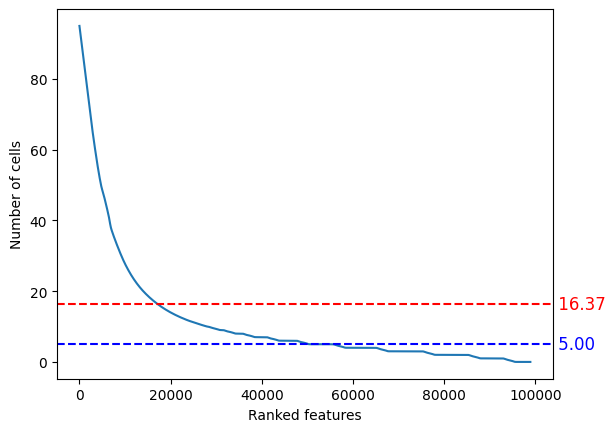

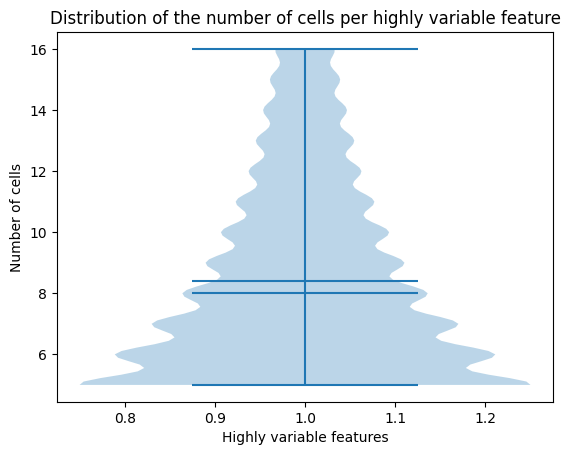

[INFO] Performing TFIDF and LSI...


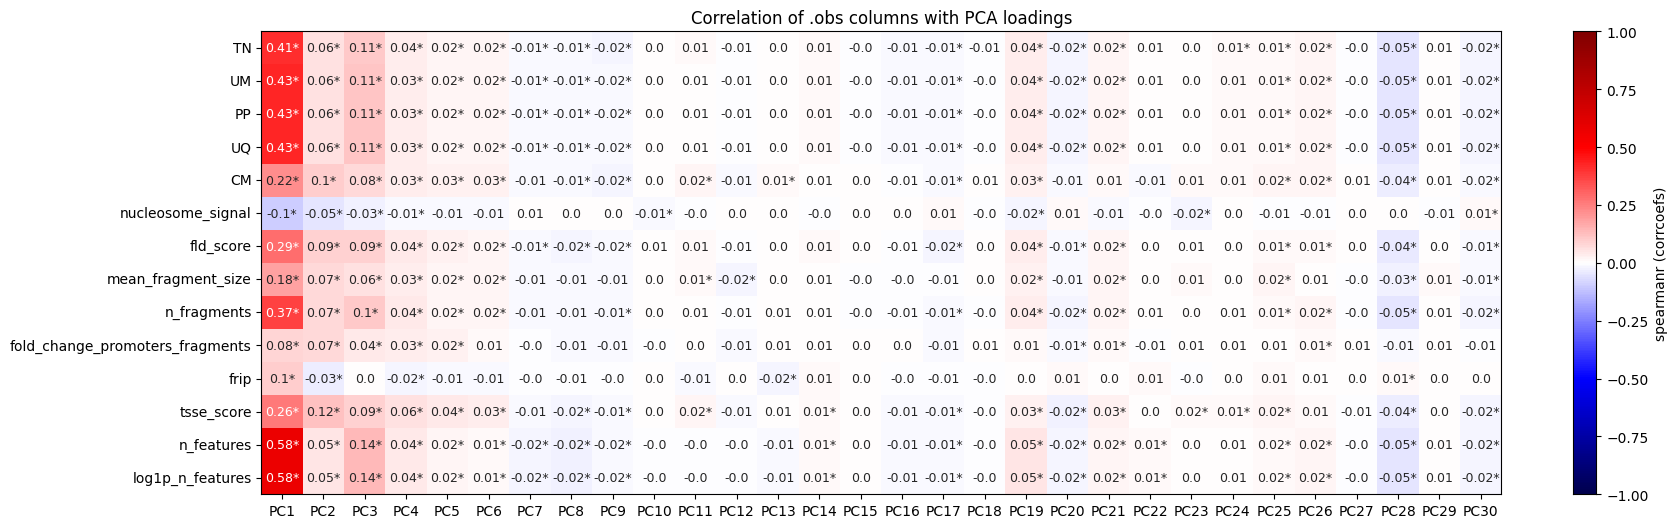

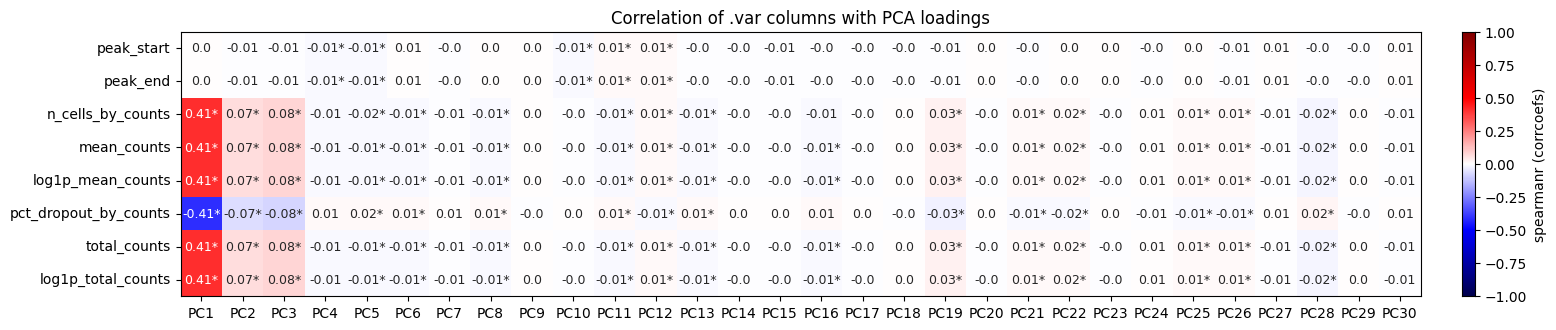

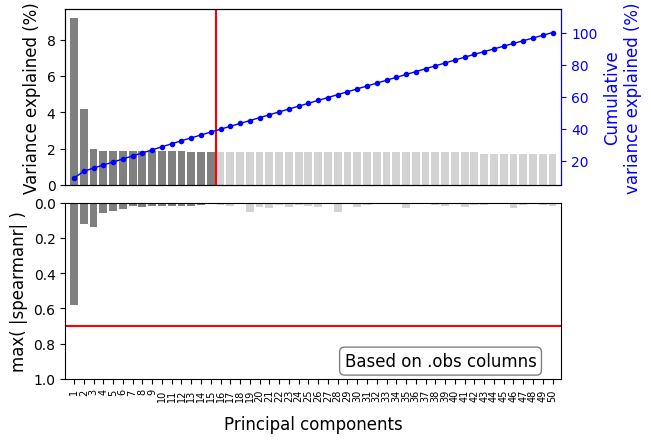

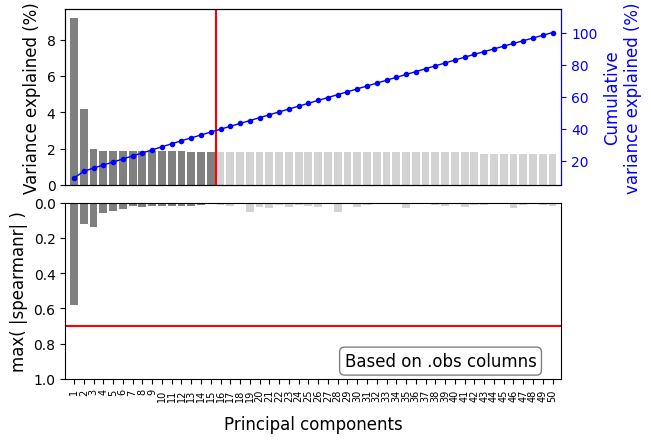

Computing chunks:  11%|█         | 105/985 [00:32<04:29,  3.27it/s]Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Computing chunks:  11%|█         | 108/985 [00:33<04:39,  3.14it/s]Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Computing chunks:  11%|█▏        | 111/985 [00:34<04:47,  3.04it/s]Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
N

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Computing chunks:  72%|███████▏  | 706/985 [03:40<01:25,  3.26it/s]Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Computing chunks:  72%|███████▏  | 709/985 [03:41<01:27,  3.15it/s]Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Computing chunks:  72%|███████▏  | 713/985 [03:42<01:20,  3.39it/s]Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
N

Embedding quality by the distance score: 1.5


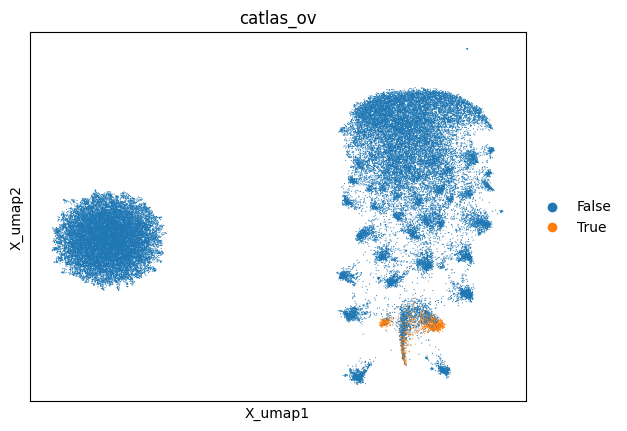

-----------------------
metric: nucleosome_signal
min: 2
max: 10
-----------------------


AnnData object with n_obs × n_vars = 3028 × 101651
    obs: 'TN', 'UM', 'PP', 'UQ', 'CM', 'file', 'sample', 'nucleosome_signal', 'fld_score', 'mean_fragment_size', 'n_fragments', 'fold_change_promoters_fragments', 'frip', 'tsse_score', 'catlas_ov', 'cell type', 'n_features', 'log1p_n_features'
    var: 'peak_chr', 'peak_start', 'peak_end', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts'
    uns: 'files', 'sctoolbox'

TN     UM     PP     UQ    CM  \
barcode                                                    
AAACTACCAGAAGCTAACGCAC   28.0   22.0   22.0   22.0   1.0   
AAACTACCAGACACGCGTGAAC   18.0   14.0   14.0   14.0   1.0   
AAACTACCAGACATGGCAAGCC   26.0   21.0   21.0   21.0   0.0   
AAACTACCAGACCCGAACTCAT    9.0    8.0    8.0    8.0   1.0   
AAACTACCAGACGCTTACCCGA   29.0   24.0   24.0   24.0   2.0   
...                       ...    ...    ...    ...   ...   
TTCCATCCTCGTCCACCTAGAC   11.0    8.0    8.0    8.0   0.0   
TTCCATCCTCTACAGCGCCGTT  171.0  159.0  159.0  159.0  39.0   
TTCCATCCTCTACCATCCCAGG    7.0    6.0    6.0    6.0   0.0   
TTCCATCCTCTACCGCTTCCAC    8.0    7.0    7.0    7.0   2.0   
TTCCATCCTCTGCGTTGATGTG    6.0    5.0    5.0    5.0   0.0   

                                                                     file  \
barcode                                                                     
AAACTACCAGAAGCTAACGCAC  /mnt/workspace2/jdetlef/peakqc_paperprep/bench...   
AAACTACCAGACACGCGTGAAC  /mnt/workspace2/jdetlef/peakqc_paperprep/bench...   
AAACTACCAGACATGGCAAGCC  /mnt/workspace2/jdetlef/peakqc_paperprep/bench...   
AAACTACCAGACCCGAACTCAT  /mnt/workspace2/jdetlef/peakqc_paperprep/bench...   
AAACTACCAGACGCTTACCCGA  /mnt/workspace2/jdetlef/peakqc_paperprep/bench...   
...                                                                   ...   
TTCCATCCTCGTCCACCTAGAC  /mnt/workspace2/jdetlef/peakqc_paperprep/bench...   
TTCCATCCTCTACAGCGCCGTT  /mnt/workspace2/jdetlef/peakqc_paperprep/bench...   
TTCCATCCTCTACCATCCCAGG  /mnt/workspace2/jdetlef/peakqc_paperprep/bench...   
TTCCATCCTCTACCGCTTCCAC  /mnt/workspace2/jdetlef/peakqc_paperprep/bench...   
TTCCATCCTCTGCGTTGATGTG  /mnt/workspace2/jdetlef/peakqc_paperprep/bench...   

                       sample  nucleosome_signal  fld_score  \
barcode                                                       
AAACTACCAGAAGCTAACGCAC     MB                3.0   4.003510   
AAACTACCAGACACGCGTGAAC     MB                2.0   2.751151   
AAACTACCAGACATGGCAAGCC     MB                2.0   3.279493   
AAACTACCAGACCCGAACTCAT     MB                2.0   2.214204   
AAACTACCAGACGCTTACCCGA     MB                2.0   1.916909   
...                       ...                ...        ...   
TTCCATCCTCGTCCACCTAGAC     MB                2.0   0.500592   
TTCCATCCTCTACAGCGCCGTT     MB                2.0  28.781028   
TTCCATCCTCTACCATCCCAGG     MB                2.0   1.019454   
TTCCATCCTCTACCGCTTCCAC     MB                2.0   0.656100   
TTCCATCCTCTGCGTTGATGTG     MB                2.0   0.436813   

                        mean_fragment_size  n_fragments  \
barcode                                                   
AAACTACCAGAAGCTAACGCAC              125.62         21.0   
AAACTACCAGACACGCGTGAAC              117.09         20.0   
AAACTACCAGACATGGCAAGCC              155.80         20.0   
AAACTACCAGACCCGAACTCAT               88.71          7.0   
AAACTACCAGACGCTTACCCGA              104.23         29.0   
...                                    ...          ...   
TTCCATCCTCGTCCACCTAGAC               92.75          4.0   
TTCCATCCTCTACAGCGCCGTT              169.60        137.0   
TTCCATCCTCTACCATCCCAGG               80.00          7.0   
TTCCATCCTCTACCGCTTCCAC              137.00          5.0   
TTCCATCCTCTGCGTTGATGTG               83.00          2.0   

                        fold_change_promoters_fragments      frip  tsse_score  \
barcode                                                                         
AAACTACCAGAAGCTAACGCAC                         0.333333  0.380952    0.000000   
AAACTACCAGACACGCGTGAAC                         0.250000  0.250000    0.000000   
AAACTACCAGACATGGCAAGCC                         0.150000  0.450000    0.000000   
AAACTACCAGACCCGAACTCAT                         0.000000  0.285714    0.000000   
AAACTACCAGACGCTTACCCGA                         0.724138  0.344828    0.669856   
...                                                 ...       ...         ...   
TTCCATCC

peak_chr  peak_start  peak_end  n_cells_by_counts  \
name                                                                       
chr1:10007-10565           chr1       10007     10565                 59   
chr1:28992-29433           chr1       28992     29433                 13   
chr1:136833-136999         chr1      136833    136999                  1   
chr1:180705-181054         chr1      180705    181054                 54   
chr1:181132-181985         chr1      181132    181985                 71   
...                         ...         ...       ...                ...   
chrY:56850348-56850516     chrY    56850348  56850516                114   
chrY:56850724-56850993     chrY    56850724  56850993                274   
chrY:56851055-56851204     chrY    56851055  56851204                 94   
chrY:56870833-56870955     chrY    56870833  56870955                 55   
chrY:56886632-56886906     chrY    56886632  56886906                 15   

                        mean_counts  log1p_mean_counts  pct_dropout_by_counts  \
name                                                                            
chr1:10007-10565           0.000849           0.000849              99.915072   
chr1:28992-29433           0.000187           0.000187              99.981287   
chr1:136833-136999         0.000014           0.000014              99.998561   
chr1:180705-181054         0.000806           0.000806              99.922270   
chr1:181132-181985         0.001022           0.001021              99.897799   
...                             ...                ...                    ...   
chrY:56850348-56850516     0.001684           0.001683              99.835903   
chrY:56850724-56850993     0.004045           0.004037              99.605591   
chrY:56851055-56851204     0.001367           0.001367              99.864692   
chrY:56870833-56870955     0.000835           0.000835              99.920830   
chrY:56886632-56886906     0.000216           0.000216              99.978408   

                        total_counts  log1p_total_counts  
name                                                      
chr1:10007-10565                59.0            4.094345  
chr1:28992-29433                13.0            2.639057  
chr1:136833-136999               1.0            0.693147  
chr1:180705-181054              56.0            4.043051  
chr1:181132-181985              71.0            4.276666  
...                              ...                 ...  
chrY:56850348-56850516         117.0            4.770685  
chrY:56850724-56850993         281.0            5.641907  
chrY:56851055-56851204          95.0            4.564348  
chrY:56870833-56870955          58.0            4.077538  
chrY:56886632-56886906          15.0            2.772589  

[101651 rows x 9 columns]

Removing chromosomal features...
Removing gender related features...


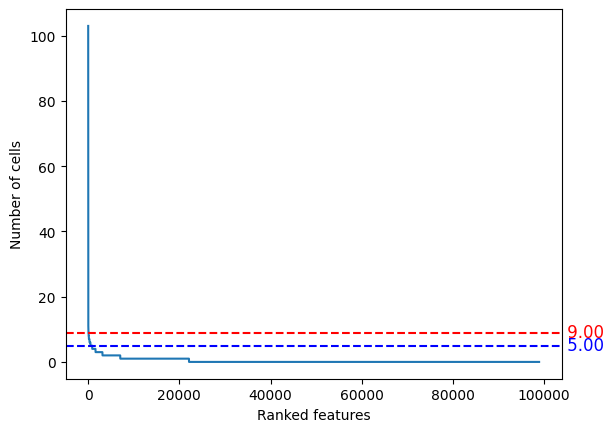

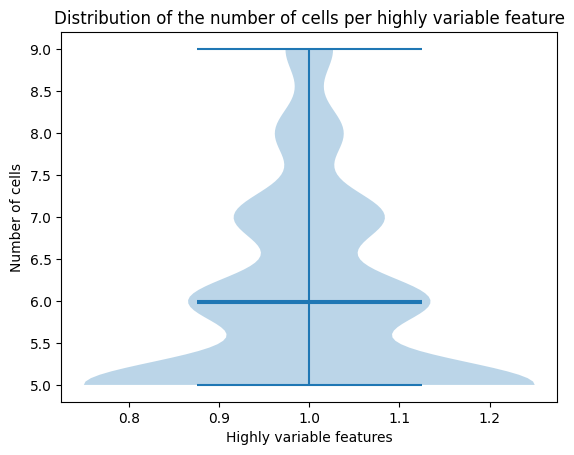

[INFO] Performing TFIDF and LSI...


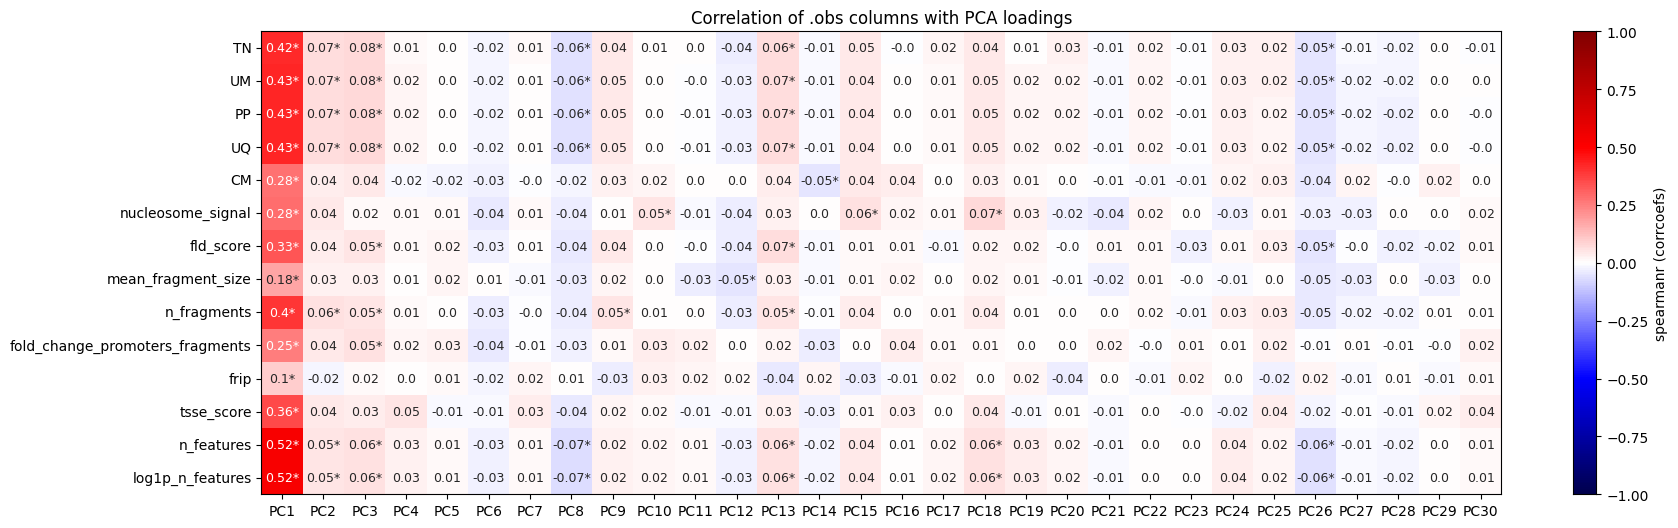

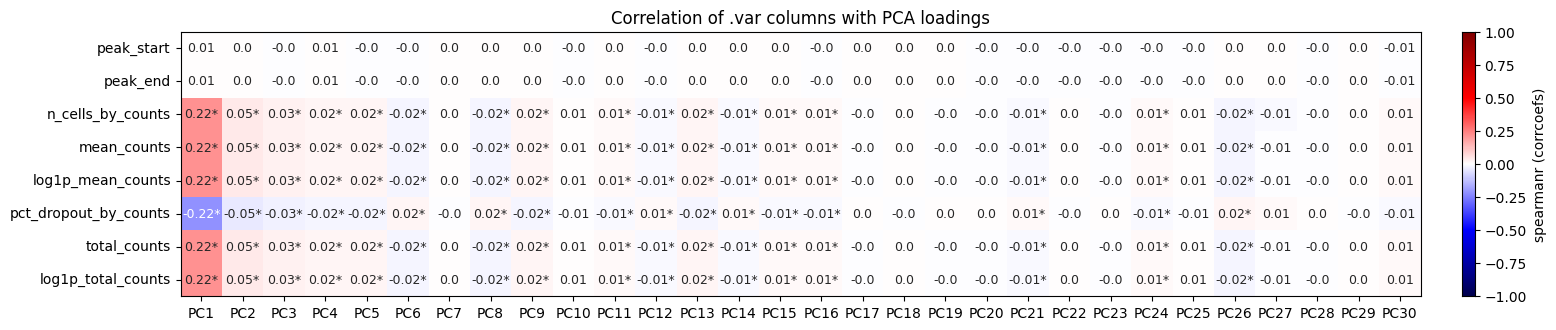

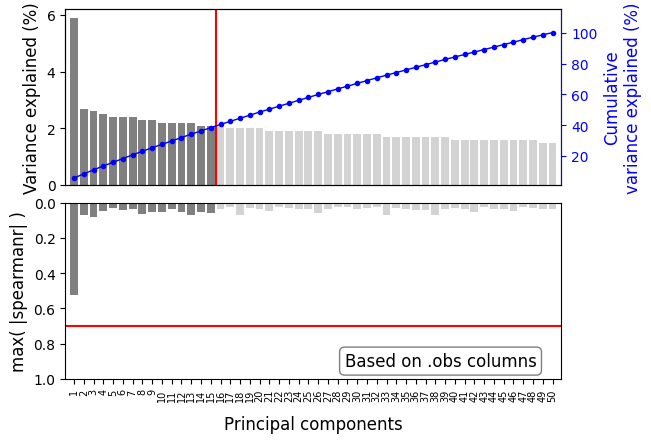

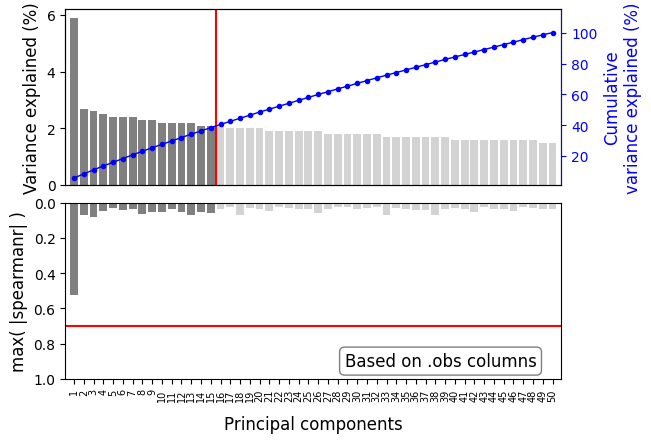

Computing chunks: 100%|██████████| 61/61 [00:13<00:00,  4.38it/s]


Embedding quality by the distance score: 1.5


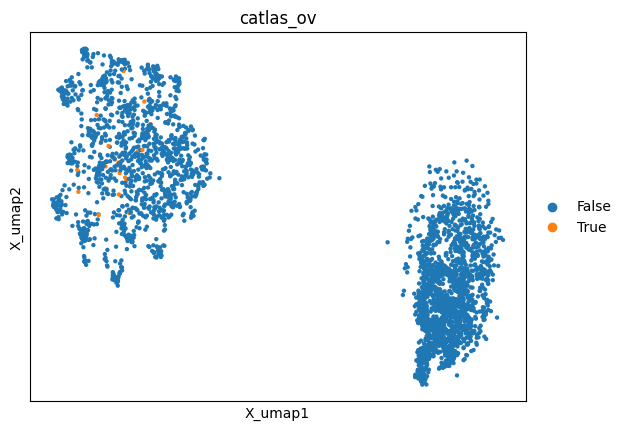

In [16]:
processed_adatas = []
for key, value in thresholds.items():
    metric = value['column']
    min_val = value['min']
    max_val = value['max']
    print('-----------------------')
    print(f'metric: {metric}')
    
    if value['column'] == 'nucleosome_signal':
        adata = full_adata[np.logical_and(full_adata.obs[value['column']] >= value['min'], 
                           full_adata.obs[value['column']] <= value['max'])].copy()
        
        print(f'min: {min_val}')
        print(f'max: {max_val}')
        
    
    if value['column'] == 'fld_score':
        adata = full_adata[full_adata.obs[value['column']] >= value['min']].copy()
        
        print(f'min: {min_val}')
        print('max: --')
        
    print('-----------------------')
        
    display(adata)
    display(adata.obs)
    display(adata.var)
    
    if filter_chrM:
        print("Removing chromosomal features...")
        non_m = [name for name in adata.var_names if not name.startswith('chrM')]  # remove chrM
        adata = adata[:, non_m]
    
    if filter_xy:
        print("Removing gender related features...")
        non_xy = [name for name in adata.var_names if not name.startswith('chrY') | name.startswith('chrX')]
        adata = adata[:, non_xy]
        
    # update number of cells per feature
    adata = tools.qc_filter.calculate_qc_metrics(adata, var_type='features')

    # drop total_counts as it is the same as n_features
    adata.obs.drop(columns=["total_counts", "log1p_total_counts"], inplace=True)

    if select_highly_variable:
        # get highly variable features
        tools.highly_variable.get_variable_features(adata, max_cells, min_cells)
        #Number of variable genes selected
        adata.var["highly_variable"].sum()
        # plot HVF violin
        pl.highly_variable.violin_HVF_distribution(adata)
        
    adata = tools.norm_correct.normalize_adata(adata, norm_method, use_highly_variable=use_highly_variable)
    
    # PCA correlations with obs variables 
    _ = pl.embedding.plot_pca_correlation(
        adata,
        n_components=n_pcs_heatmap,
        which="obs",
        title="Correlation of .obs columns with PCA loadings",
        save="PCA_correlation_obs.pdf"
    )
    plt.show()
    
     # PCA correlations with var variables
    _ = pl.embedding.plot_pca_correlation(
        adata,
        n_components=n_pcs_heatmap,
        which="var",
        title="Correlation of .var columns with PCA loadings",
        save="PCA_correlation_var.pdf"
    )
    plt.show()
    
    selected_pcs = tools.dim_reduction.propose_pcs(
    anndata=adata,
    how=filter_methods,
    corr_thresh=corr_thresh,
    perc_thresh=perc_thresh,
    corr_kwargs={'method': 'spearmanr', 'which': basis, 'ignore': ignore_cols}
    )

    # Plot and select number of PCs
    _ = pl.embedding.plot_pca_variance(
        adata, 
        save='PCA_variance_proposed_selection.pdf',
        selected=selected_pcs,
        n_pcs=50,
        n_thresh=max(selected_pcs),
        corr_plot='spearmanr',
        corr_thresh=corr_thresh,
        corr_on=basis,
        ignore=ignore_cols
    )
    plt.show()
    
    final_pc_selection = selected_pcs
    
    _ = pl.embedding.plot_pca_variance(
        adata, 
        selected=final_pc_selection if subset_pcs else None,
        save='PCA_variance_final_selection.pdf',
        n_pcs=50,
        n_thresh=max(selected_pcs) if subset_pcs else None,
        corr_plot='spearmanr',
        corr_thresh=corr_thresh if subset_pcs else None,
        corr_on=basis,
        ignore=ignore_cols
    )
    plt.show()
    
    # Subset the number of pcs if chosen in the parameters
    if subset_pcs:
        tools.dim_reduction.subset_PCA(adata, select=final_pc_selection)
        
    sc.pp.neighbors(adata, n_neighbors=n_neighbors, method='umap', metric='euclidean')
    
    sc.tl.umap(adata, min_dist=min_dist, spread=spread, n_components=n_components)
    # When binarizing at the beginning normalization is introducing floats again
    # Below is Done to calculate the Quality Metrics

    # save a binary layer
    adata.layers["processed"] = adata.X

    # binarize
    epi.pp.binarize(adata)
    adata.layers["binary"] = adata.X
    
    add_similarity(adata, 
               distance=False, 
               n_cells=20, 
               embedding='X_umap', 
               threads=10, 
               chunksize=50, 
               highly_variable=True)
    
    distance_score = adata.obs['distance_score'].median()
    
    print(f'Embedding quality by the distance score: {distance_score}')
    
    sc.pl.embedding(adata, basis="X_umap", color="catlas_ov", show=True)
    
    processed_adatas.append(adata)

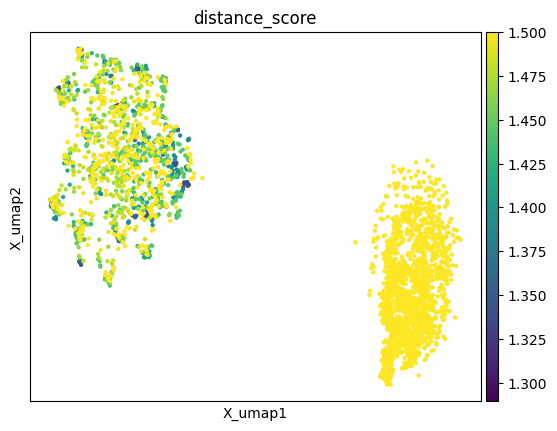

In [17]:
sc.pl.embedding(adata, basis="X_umap", color="distance_score", show=True)